# Analytics - Product Quality

#### Date: 29/06/2023

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above.

### TEAM: AMIS

##### Semester: 2023/01
##### Professor: Hilmer Neri

##### Members:
#### EPS

- Gustave Persijn
- Bianca Sofia
- Lorrayne Cardozo
- Pedro Henrique
- Lorrany Oliveira

#### MDS

- Caio Lucas
- Maria Luisa
- Erick Miranda
- Caua Matheus
- Caio Felipe
- Doan de Jesus
- Gabriela Silva
- Iago Rocha
- Felipe Aguiar
- Eric Akio

### LIBRARIES

In [171]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

### GRAPH SETTINGS

In [172]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [173]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [174]:
# Set your repo major name here
repo_name = 'fga-eps-mds-2023.1-Amis-'

# Add your repos here
repos_language = {
    'Front': 'ts',
    'UserService': 'py',
    'ClassroomService': 'py',
    'ProductionService': 'py',
}


### SonarCloud
##### Path to the folder with all your jsons

In [175]:
sonar_files = glob('./analytics-raw-data/*.json')

In [176]:
sonar_files

['./analytics-raw-data/fga-eps-mds-2023.1-Amis-Front-07-09-2023-13-49-31-main.json',
 './analytics-raw-data/fga-eps-mds-2023.1-Amis-Front-07-09-2023-12-29-46-main.json',
 './analytics-raw-data/fga-eps-mds-2023.1-Amis-Front-07-06-2023-18-34-40-main.json',
 './analytics-raw-data/fga-eps-mds-2023.1-Amis-Front-07-01-2023-11-50-39-main.json',
 './analytics-raw-data/fga-eps-mds-2023.1-Amis-UserService-06-27-2023-20-44-03-v1.2.0.json',
 './analytics-raw-data/fga-eps-mds-2023.1-Amis-Front-06-26-2023-22-36-25-main.json',
 './analytics-raw-data/fga-eps-mds-2023.1-Amis-Front-05-26-2023-20-13-31-main.json',
 './analytics-raw-data/fga-eps-mds-2023.1-Amis-Front-06-13-2023-20-01-26-main.json',
 './analytics-raw-data/fga-eps-mds-2023.1-Amis-Front-05-23-2023-23-15-17-main.json',
 './analytics-raw-data/fga-eps-mds-2023.1-Amis-ClassroomService-07-09-2023-19-29-54-v4.0.0.json',
 './analytics-raw-data/fga-eps-mds-2023.1-Amis-Front-07-07-2023-17-06-35-main.json',
 './analytics-raw-data/fga-eps-mds-2023.1-Am

## Create DataFrame

#### Unmarshall json

In [177]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [178]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [179]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [180]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [181]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(0)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [182]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)

        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[base_name.split("-")[5]])


        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)

    df['repository'] = aux_df[0]
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'datetime'])

    return df

### Create dataframe per repository

In [183]:
file_component_df = create_component_df(sonar_files)
file_component_df.repository.unique()

array(['fga-eps-mds-2023.1-Amis-ClassroomService',
       'fga-eps-mds-2023.1-Amis-Front',
       'fga-eps-mds-2023.1-Amis-ProductionService',
       'fga-eps-mds-2023.1-Amis-UserService'], dtype=object)

In [184]:
repos_dataframes = []

for repo in repos_language.keys():
    dataframe = file_component_df[file_component_df['repository'] == repo_name+repo]
    repos_dataframes.append({'name': repo, 'df': dataframe})

## Measure calculations according to Q-Rapids quality model

In [185]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [186]:
def m1(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [187]:
def m2(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [188]:
def m3(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [189]:
def m4(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [190]:
def m5(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [191]:
def m6(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [192]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(m1(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(m2(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(m3(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(m4(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(m5(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(m6(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'm1': m1_list,
        'm2': m2_list,
        'm3': m3_list,
        'm4': m4_list,
        'm5': m5_list,
        'm6': m6_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [193]:
# Here we will create a dictionary with the metrics for each repository
metrics = {}

for repo_df in repos_dataframes:
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])

## Data visualization

In this area you will need to plot the metrics of each repository.

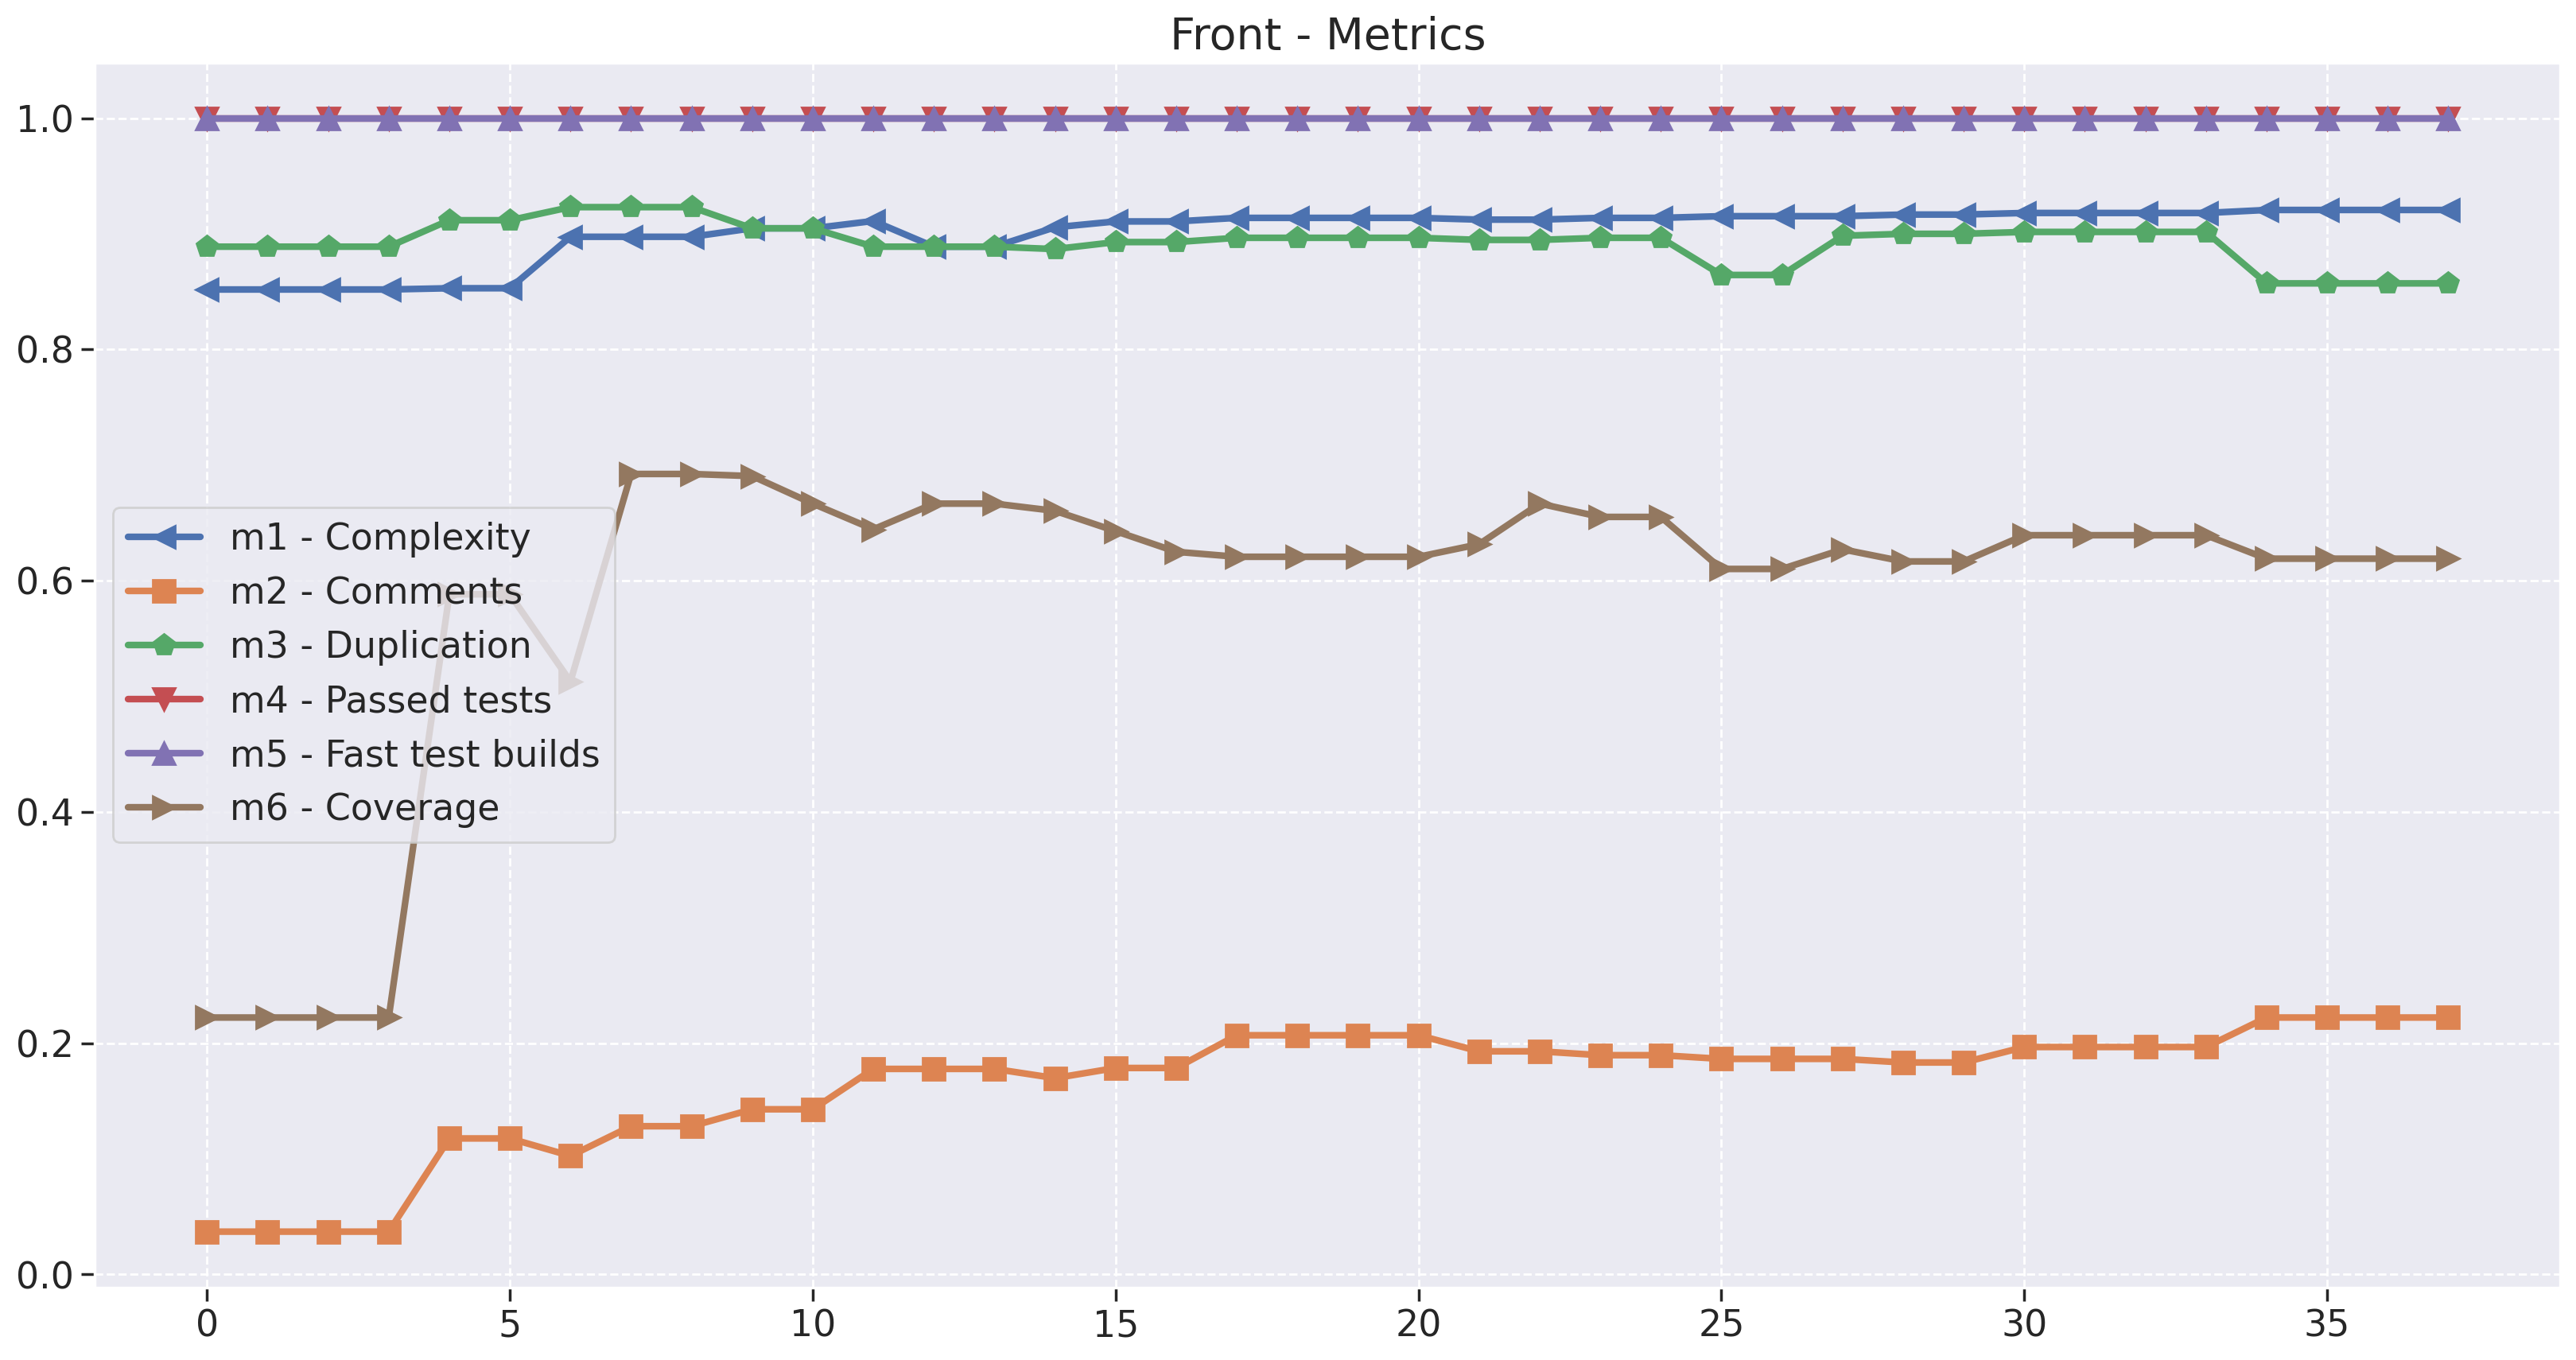

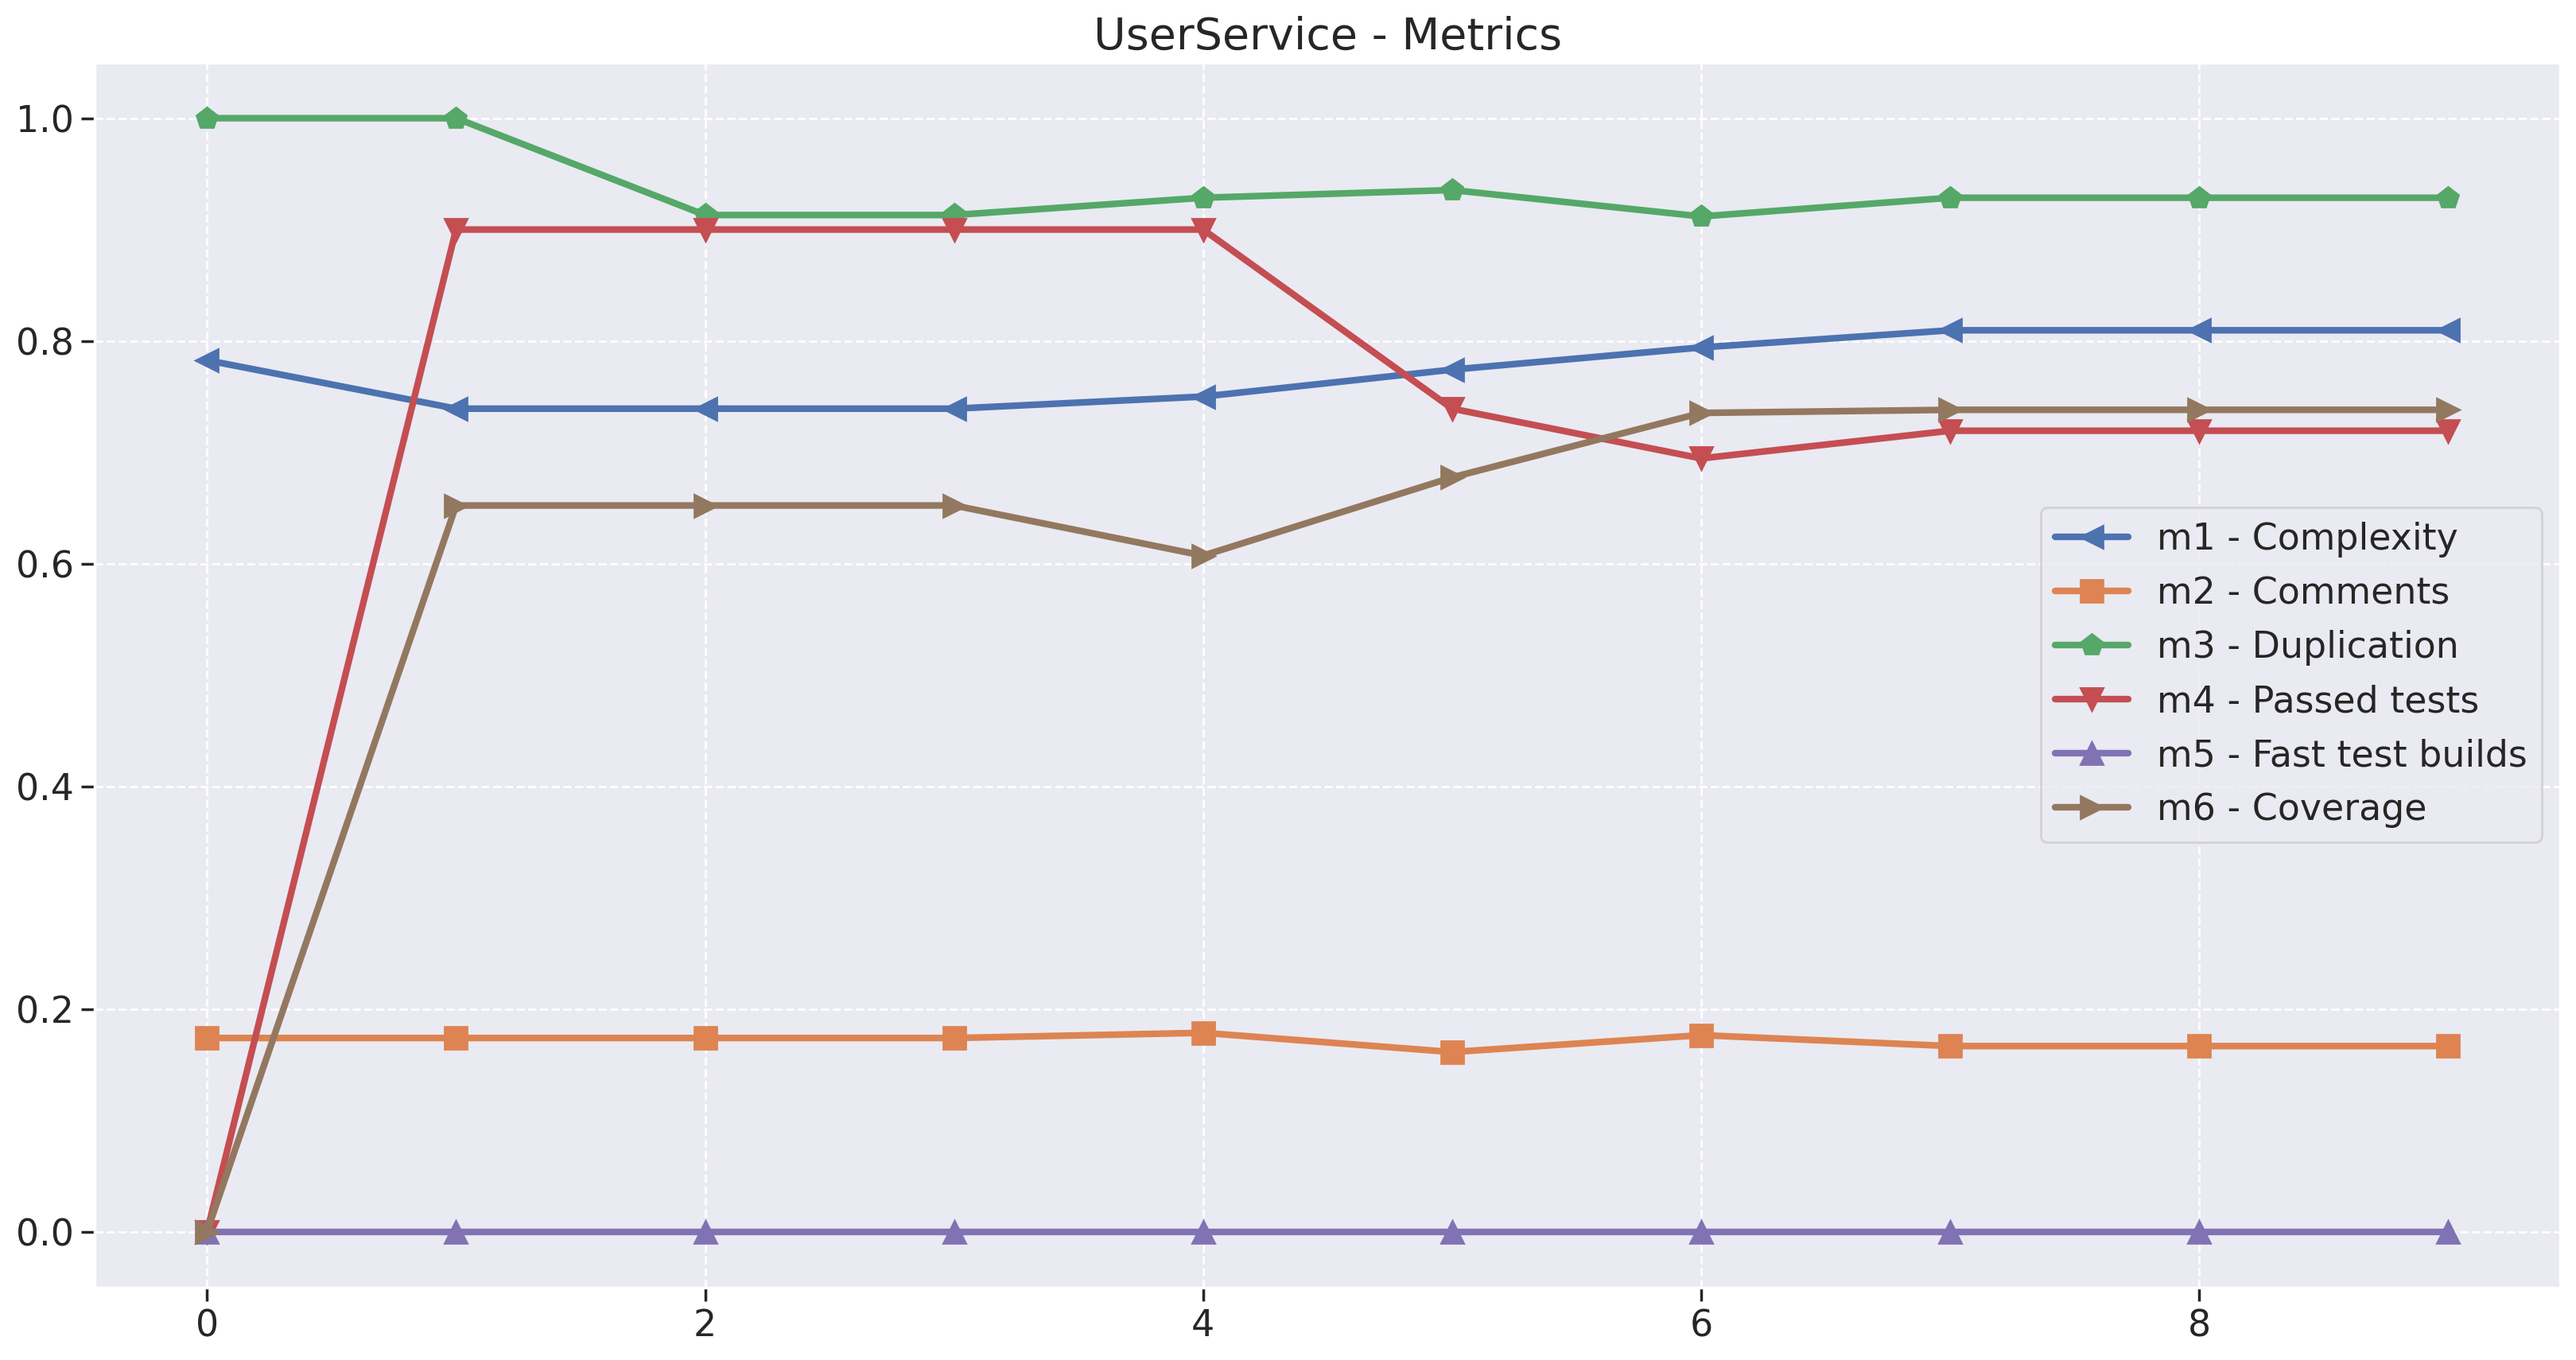

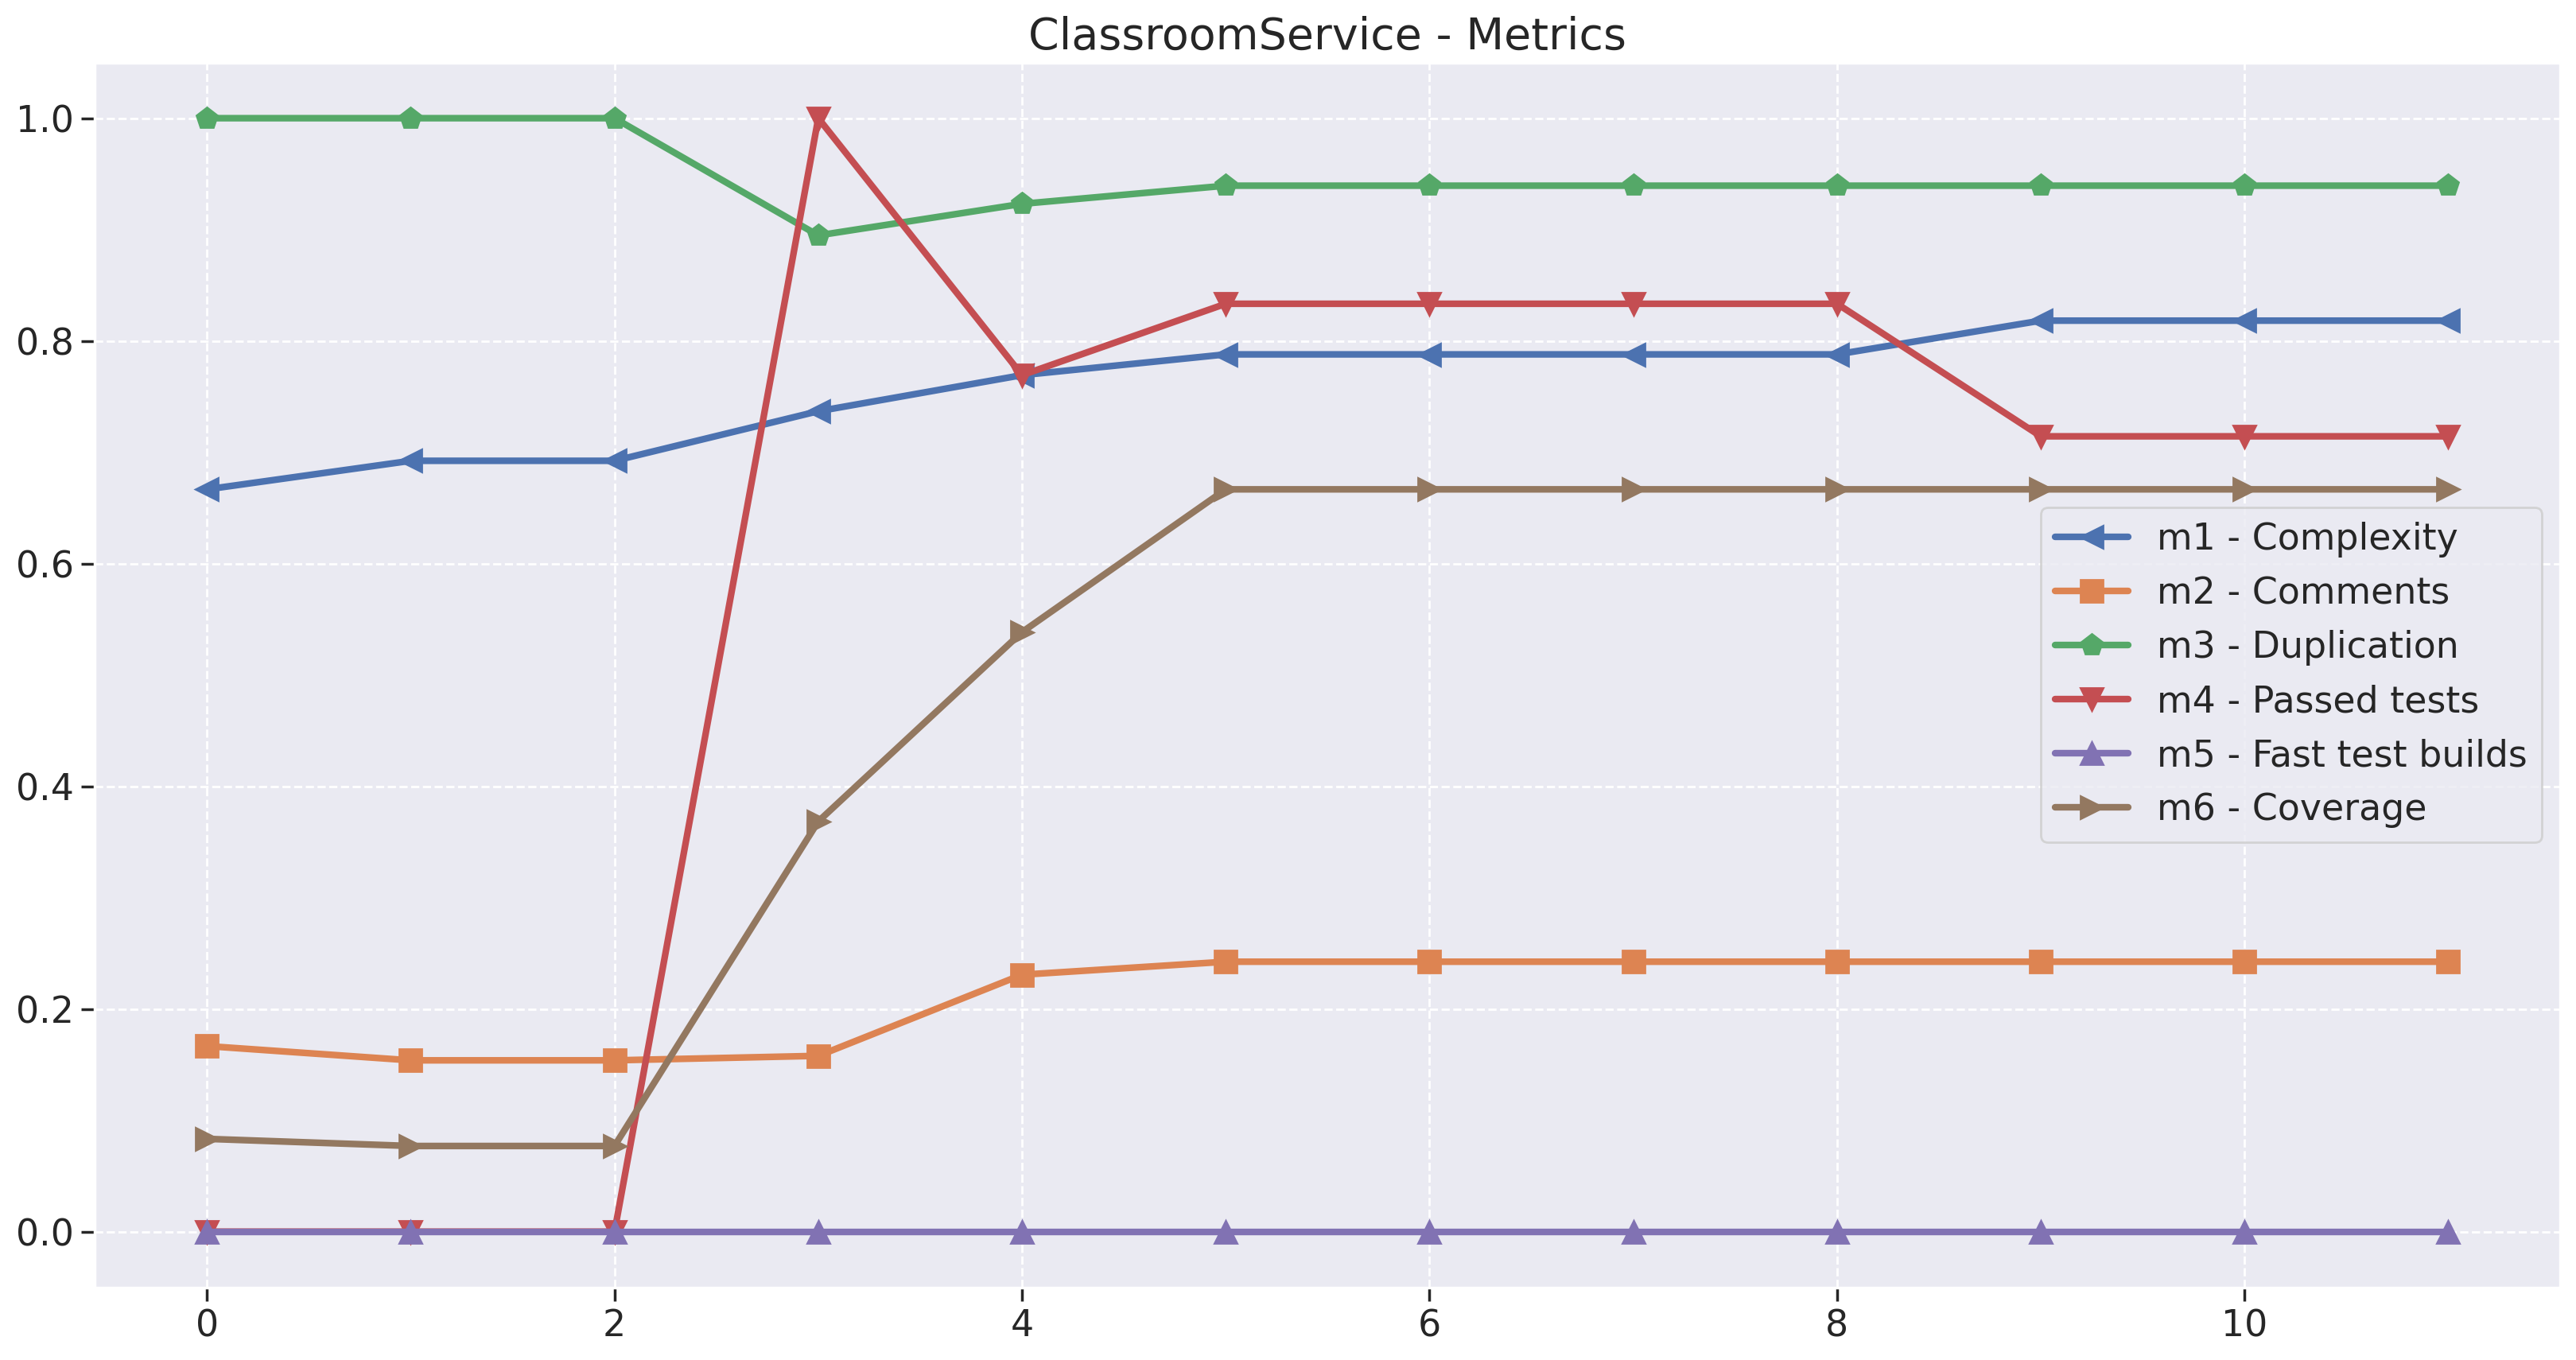

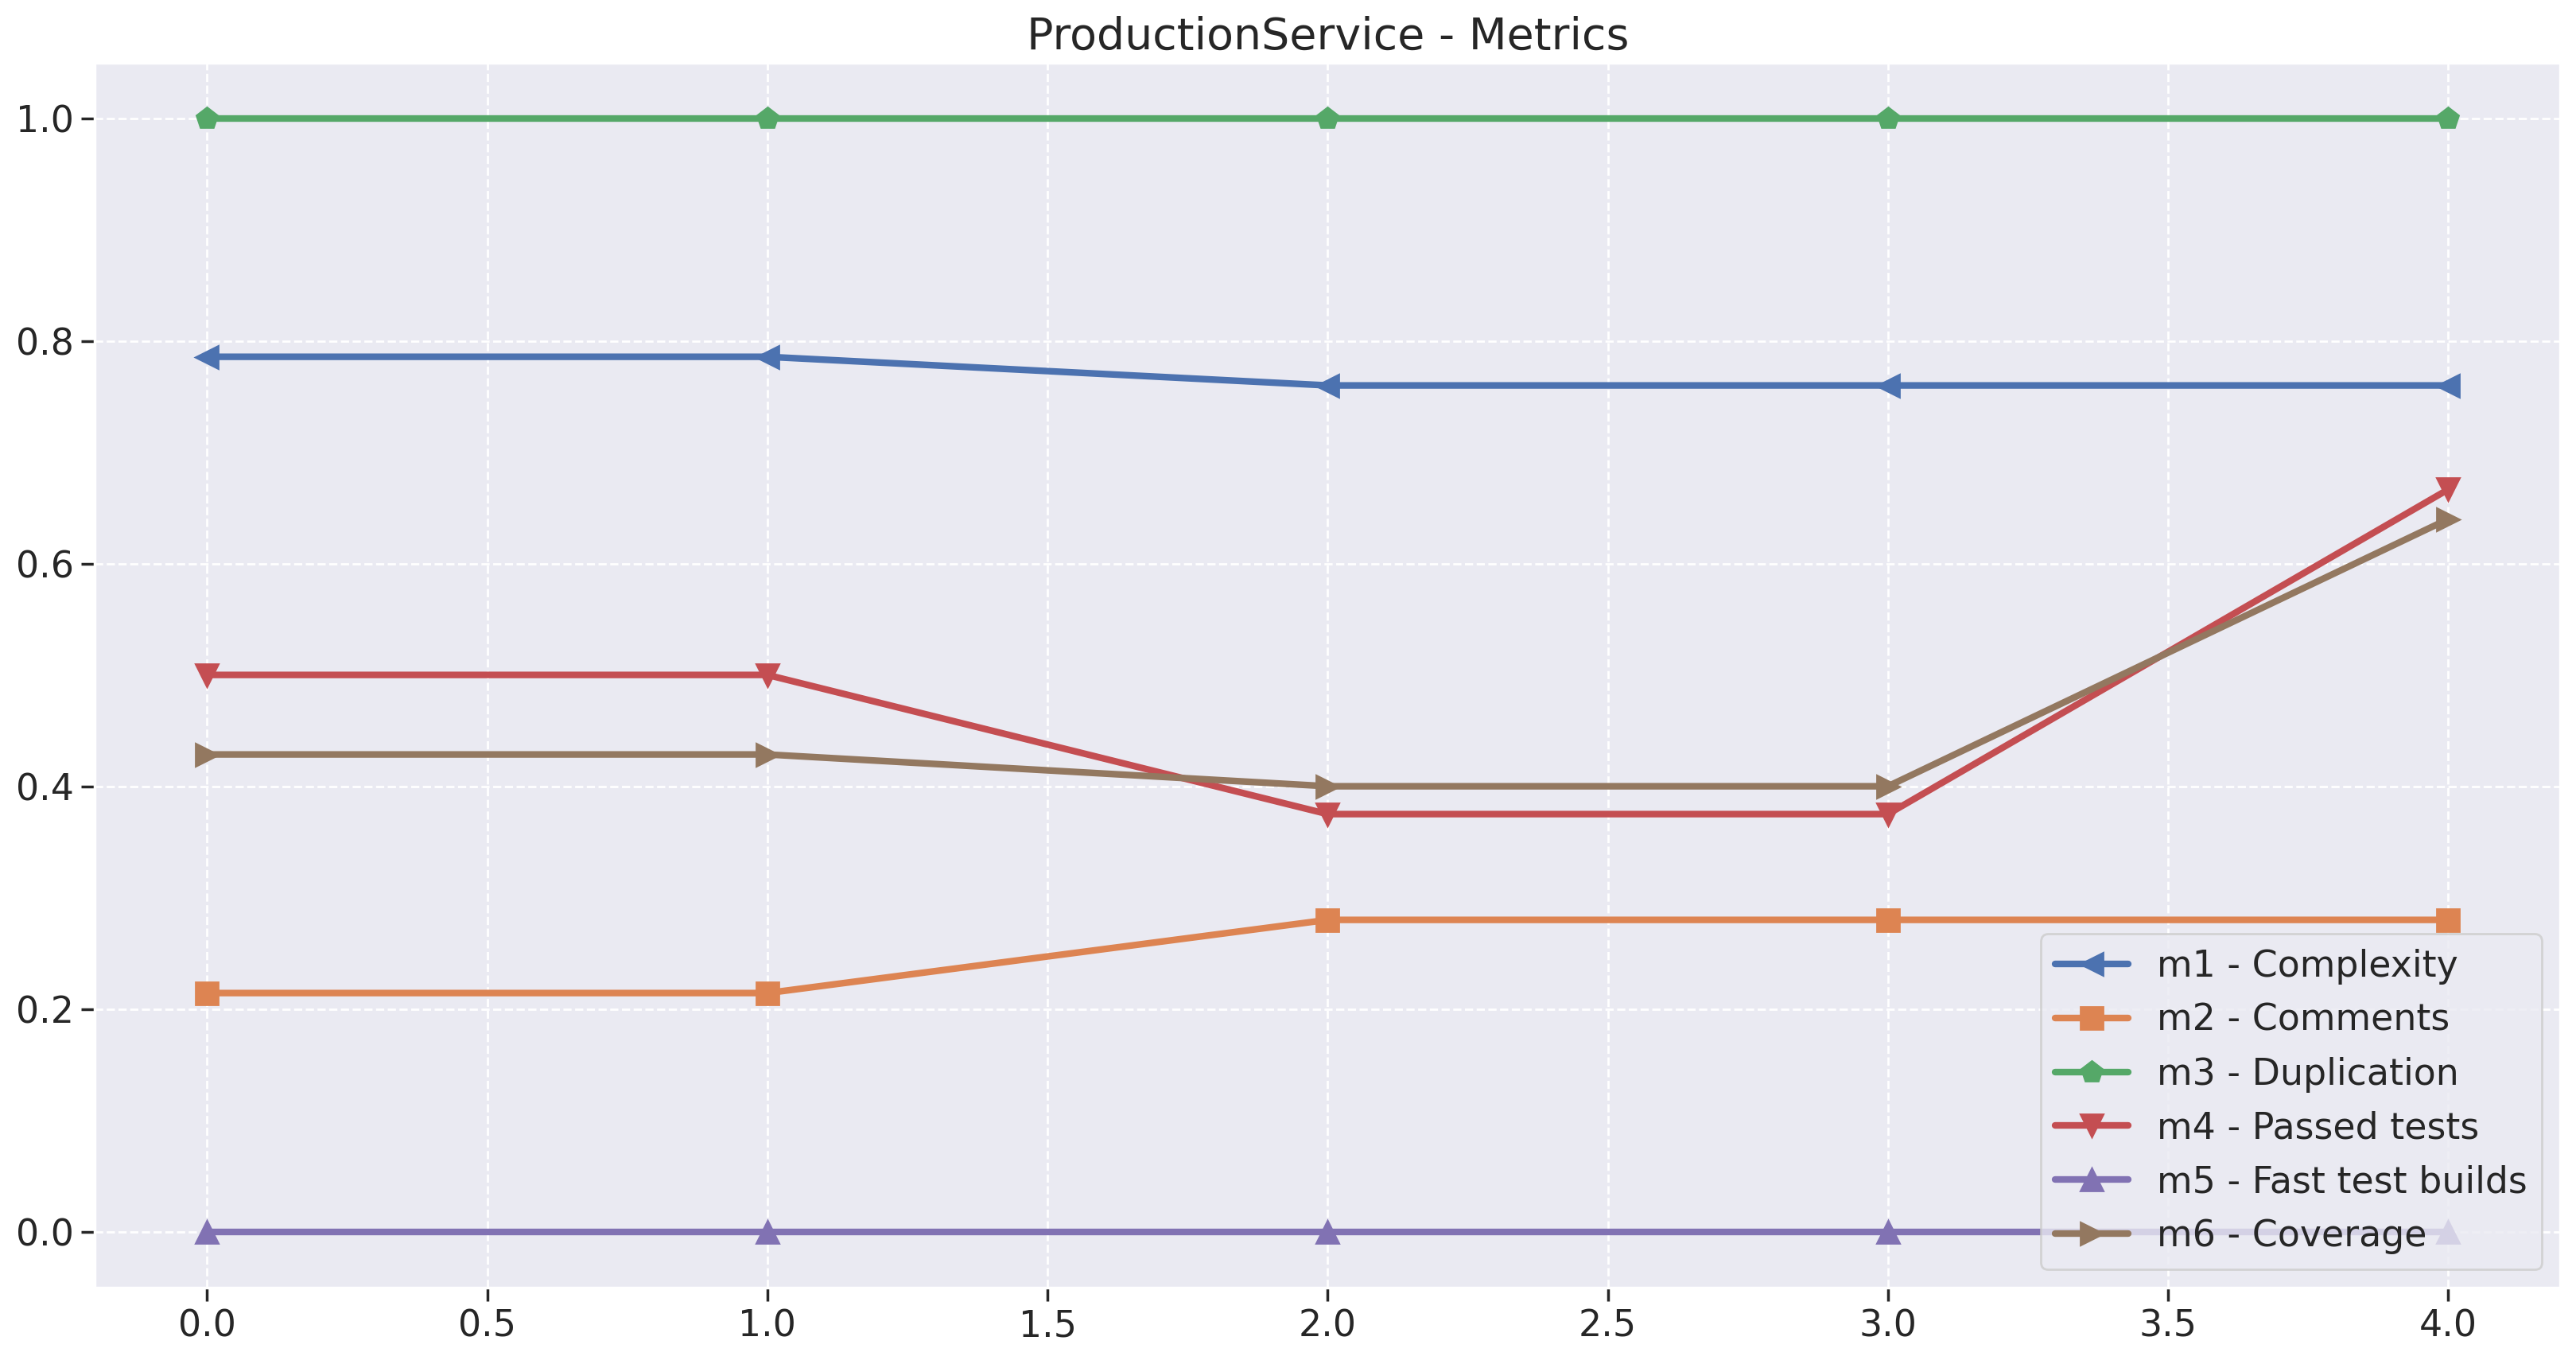

In [194]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['m1'], linewidth=3, marker='<', markersize=10, label="m1 - Complexity")
    plt.plot(data['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
    plt.plot(data['m3'], linewidth=3, marker='p', markersize=10, label="m3 - Duplication")
    plt.plot(data['m4'], linewidth=3, marker='v', markersize=10, label="m4 - Passed tests")
    plt.plot(data['m5'], linewidth=3, marker='^', markersize=10, label="m5 - Fast test builds")
    plt.plot(data['m6'], linewidth=3, marker='>', markersize=10, label="m6 - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

## Quality factor and aspect aggregation

In [195]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository.

for name, data in metrics.items():
    data['code_quality'] = ((data['m1']*pm1) + (data['m2']*pm2) + (data['m3']*pm3)) * psc1
    data['testing_status'] = ((data['m4']*pm4) + (data['m5']*pm5) + (data['m6']*pm6)) * psc2

### Code Quality visualization

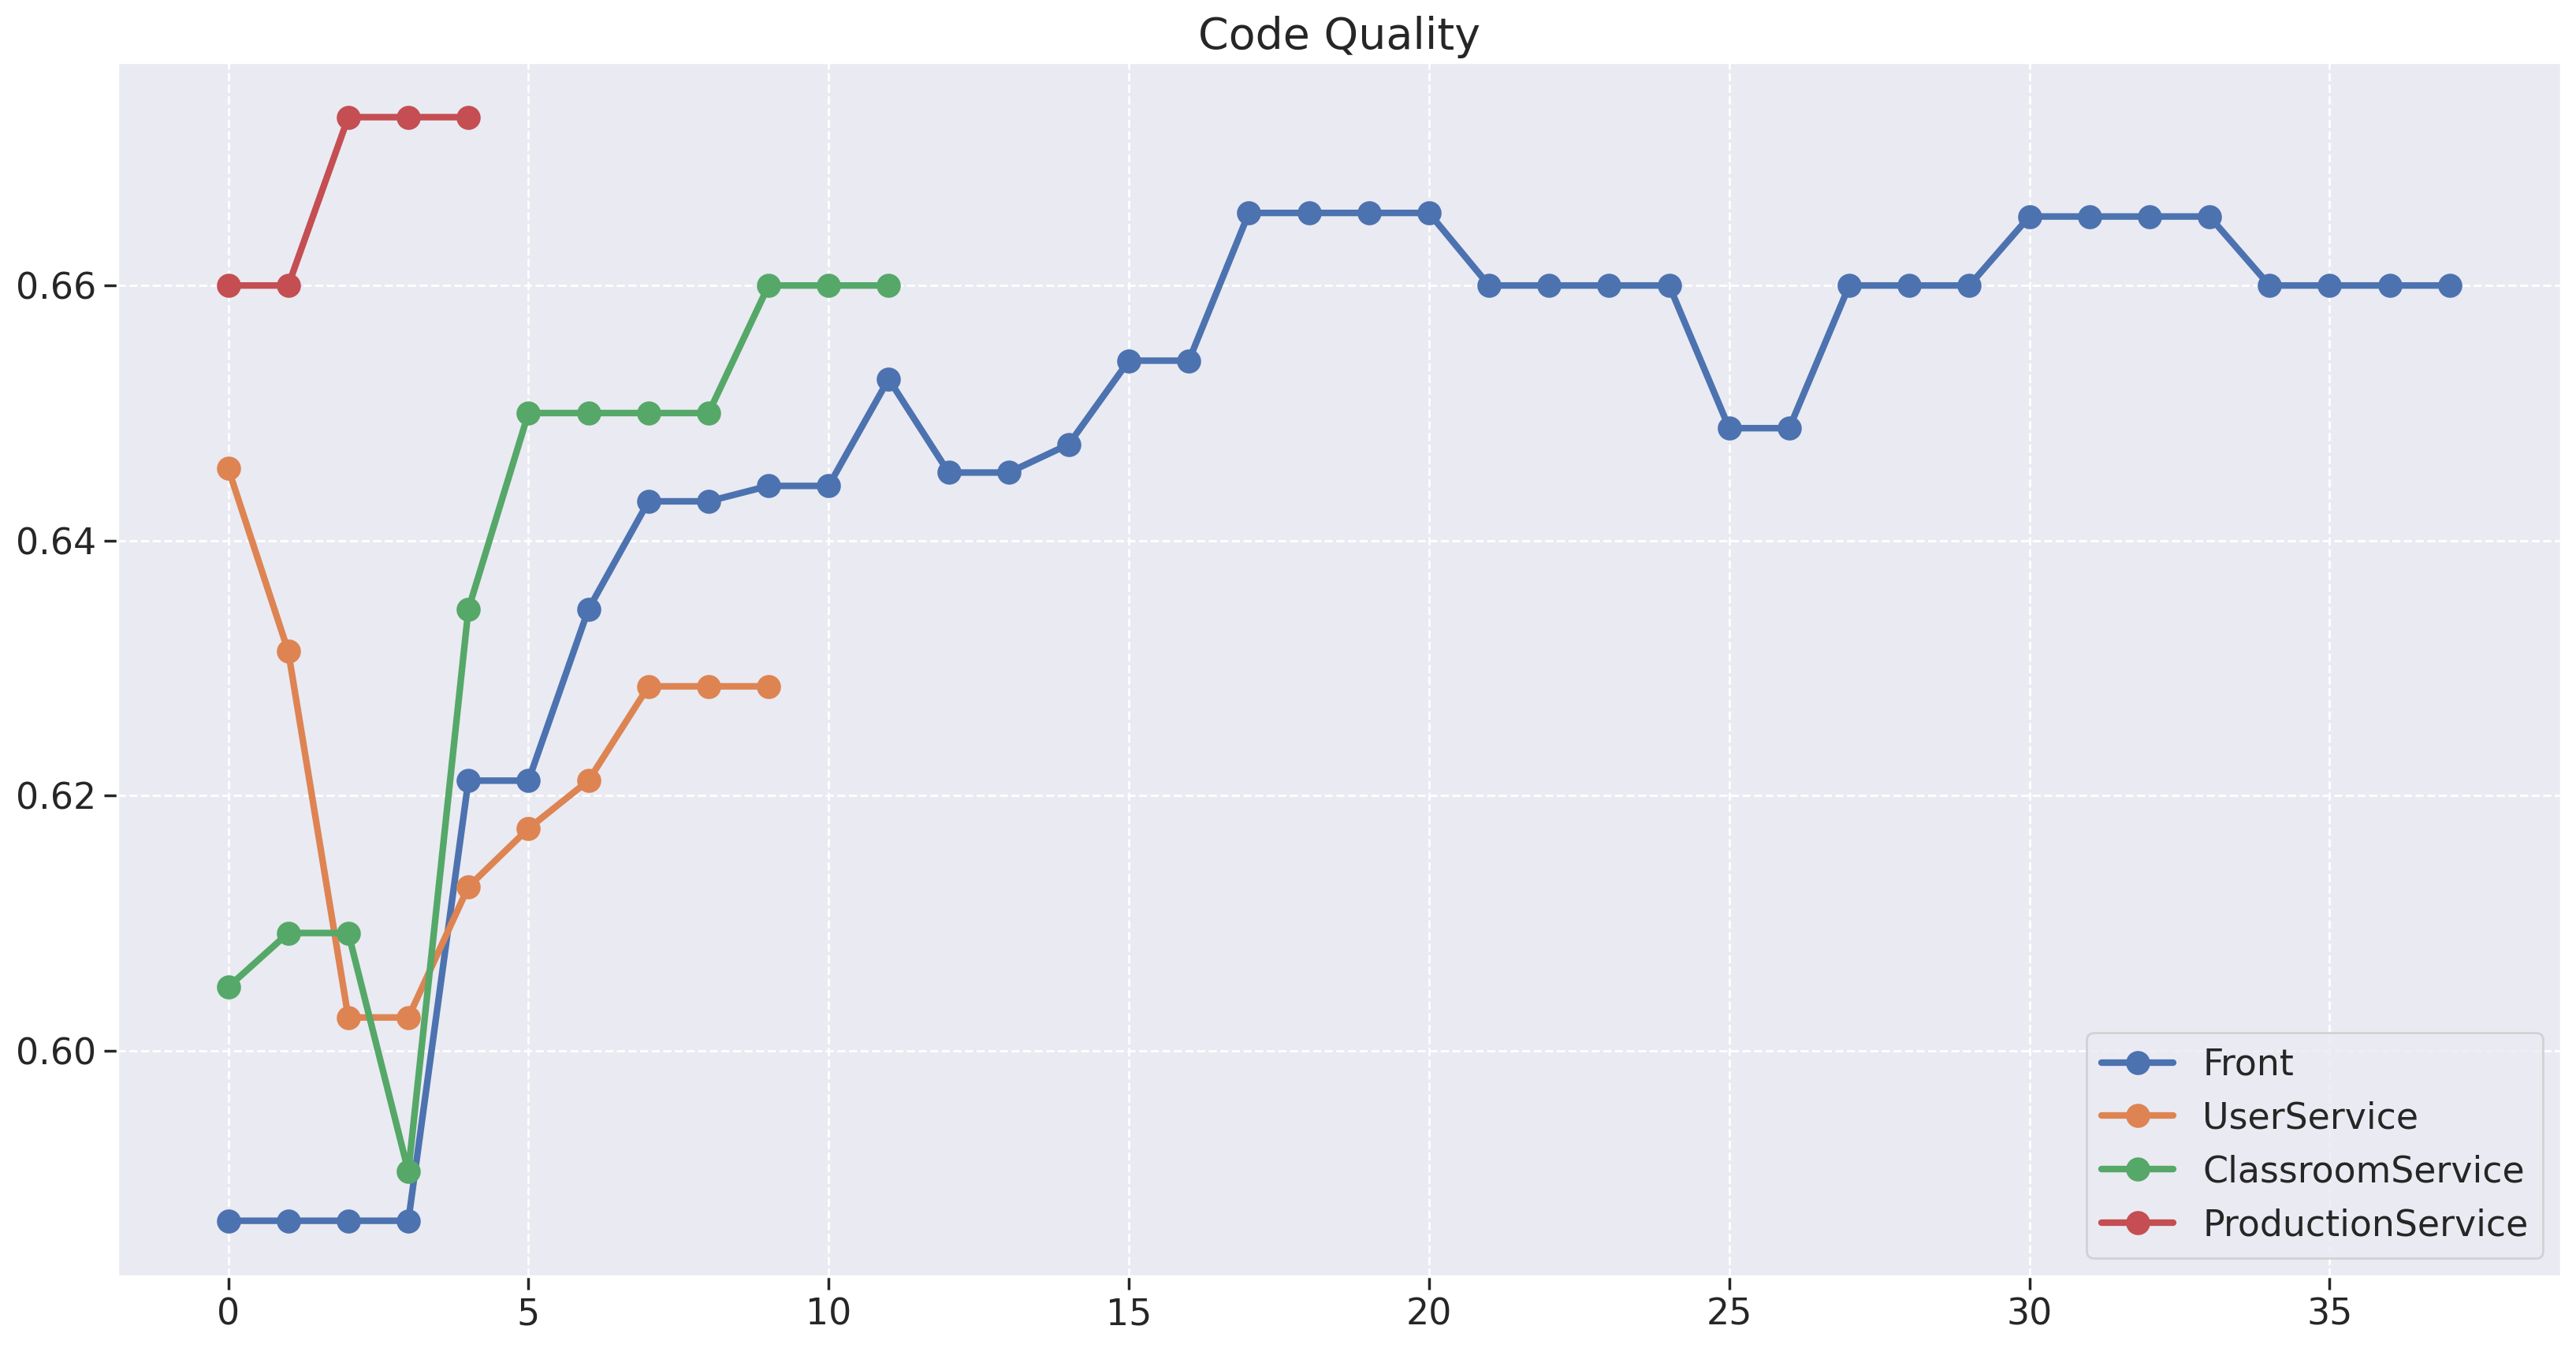

In [196]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

### Testing Status visualization

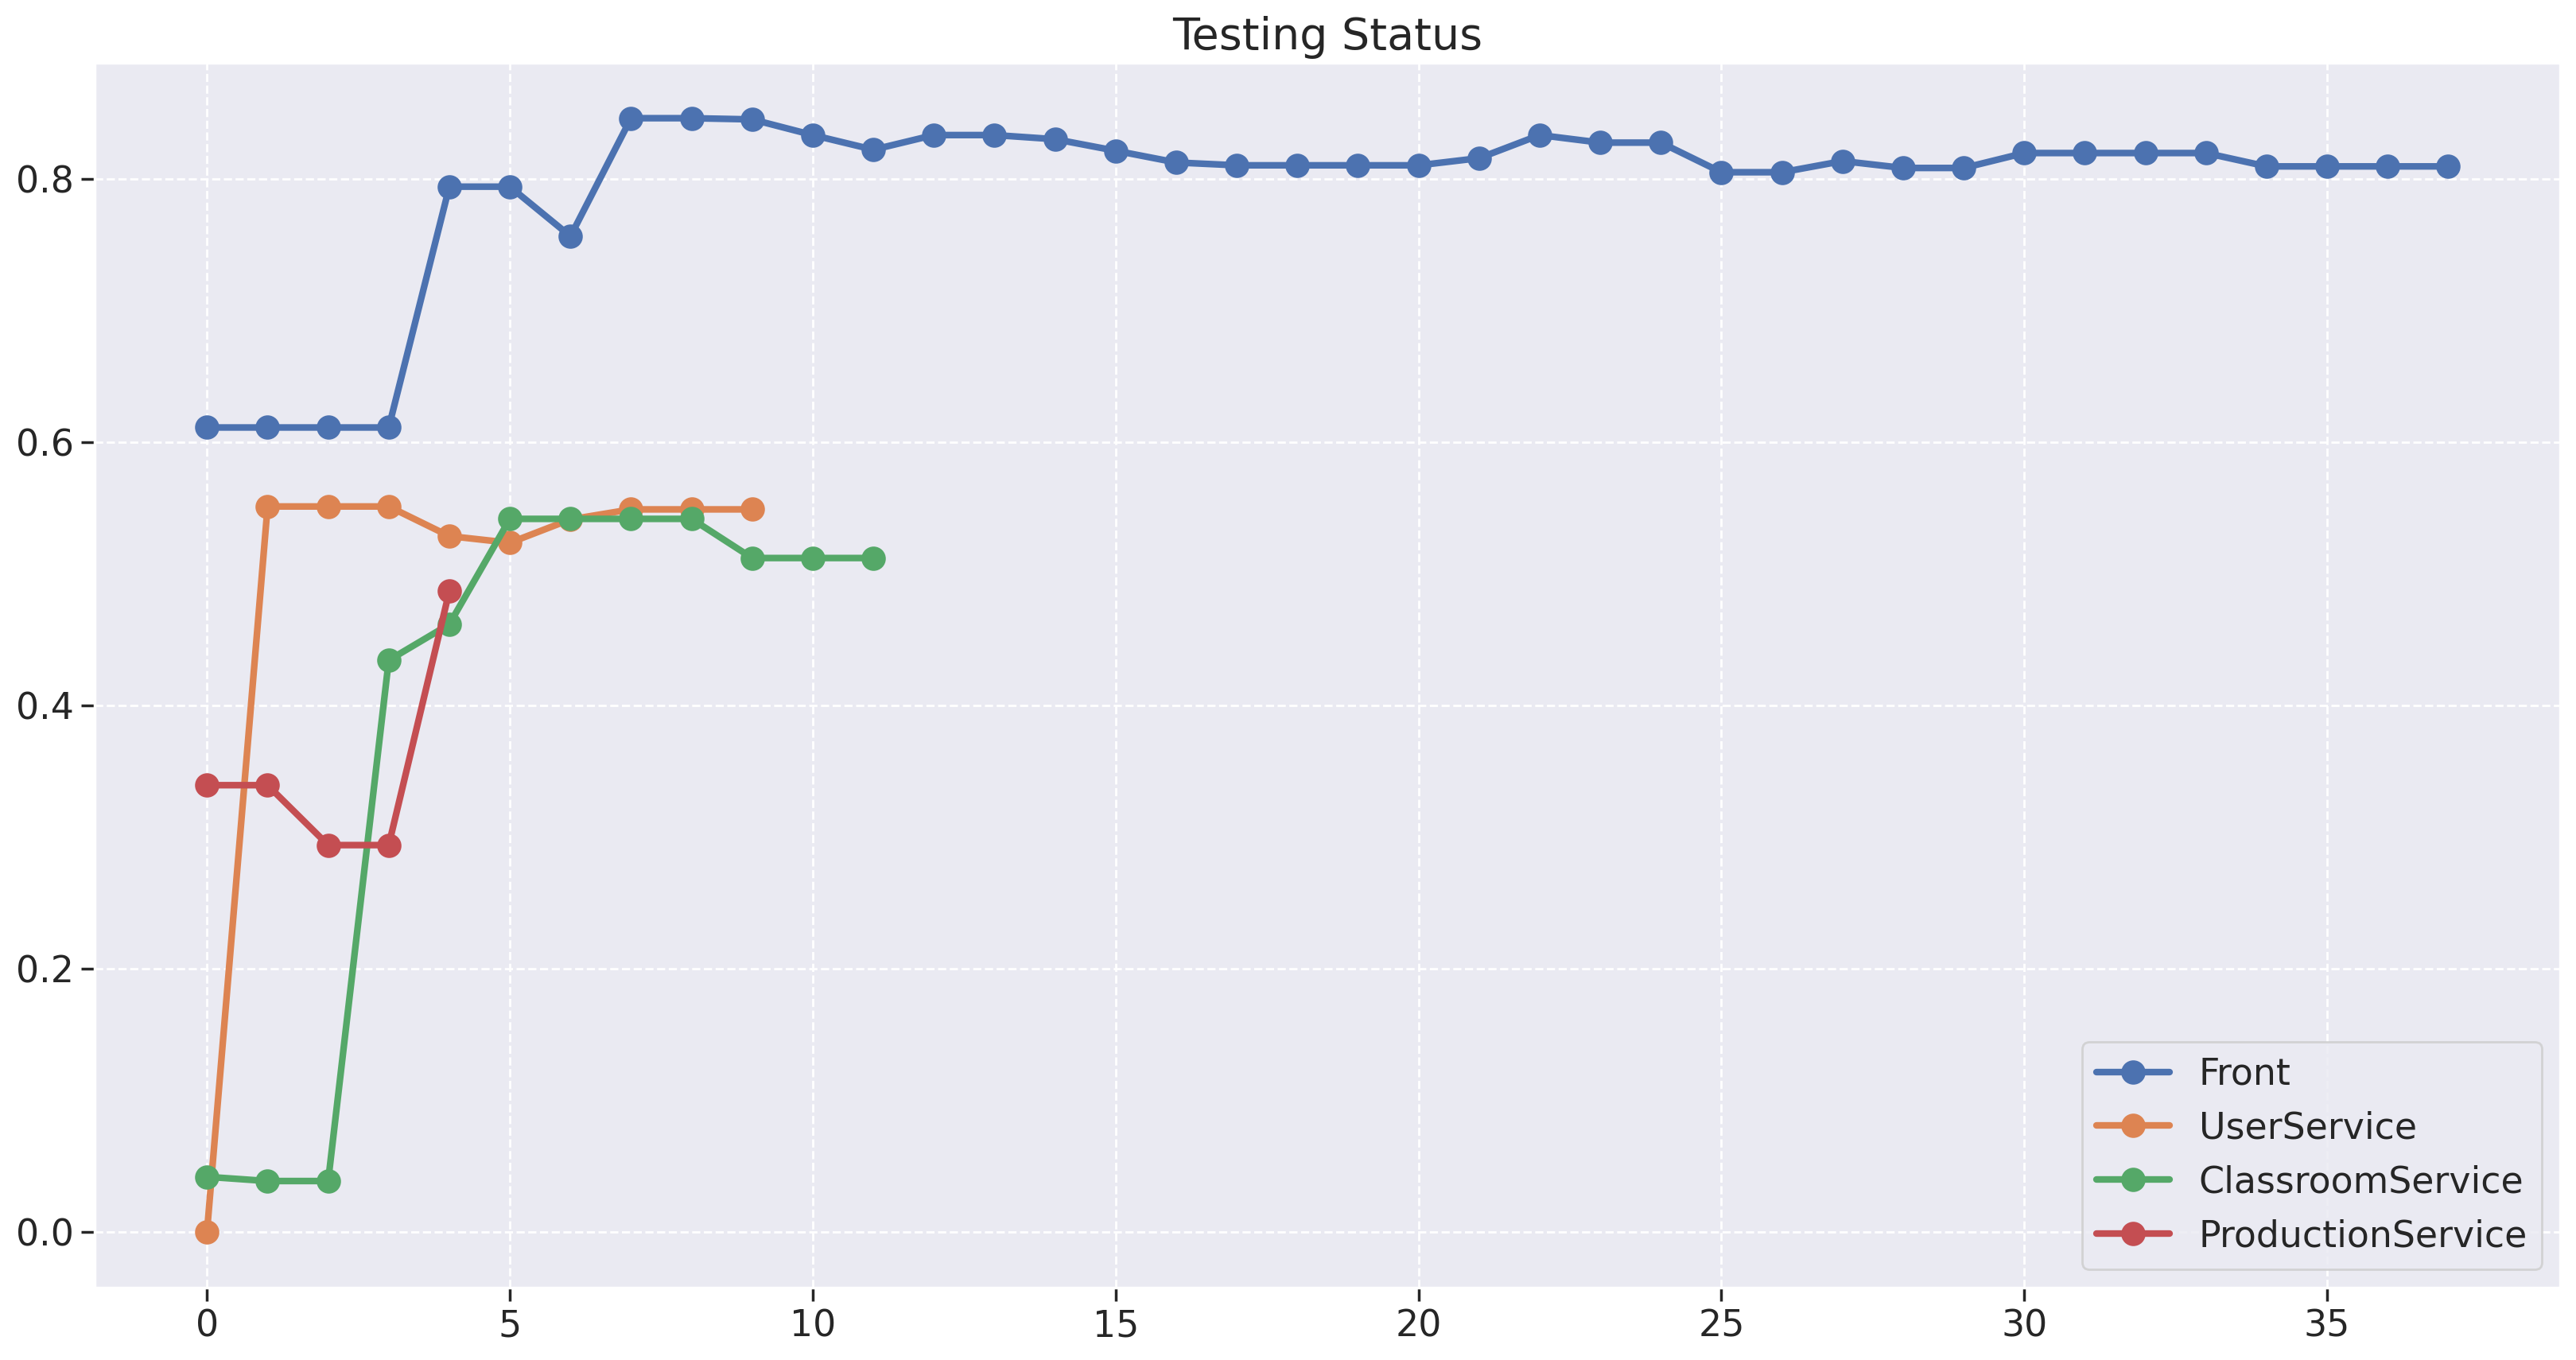

In [197]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')
plt.show()

### Aggregations

In [198]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

## Repositories analysis

In [199]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [200]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=10, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=10, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

### Analysis loop in each repo

Front
Maintainability Stats
    mean  mode   median      std      var      min      max
0.323414  0.33 0.328527 0.011869 0.000141 0.293333 0.332845
Reliability Stats
    mean     mode   median      std      var      min      max
0.397577 0.305556 0.405711 0.032987 0.001088 0.305556 0.423077
0.397577 0.404762 0.405711 0.032987 0.001088 0.305556 0.423077
0.397577 0.405172 0.405711 0.032987 0.001088 0.305556 0.423077
0.397577 0.409836 0.405711 0.032987 0.001088 0.305556 0.423077
0.397577 0.416667 0.405711 0.032987 0.001088 0.305556 0.423077


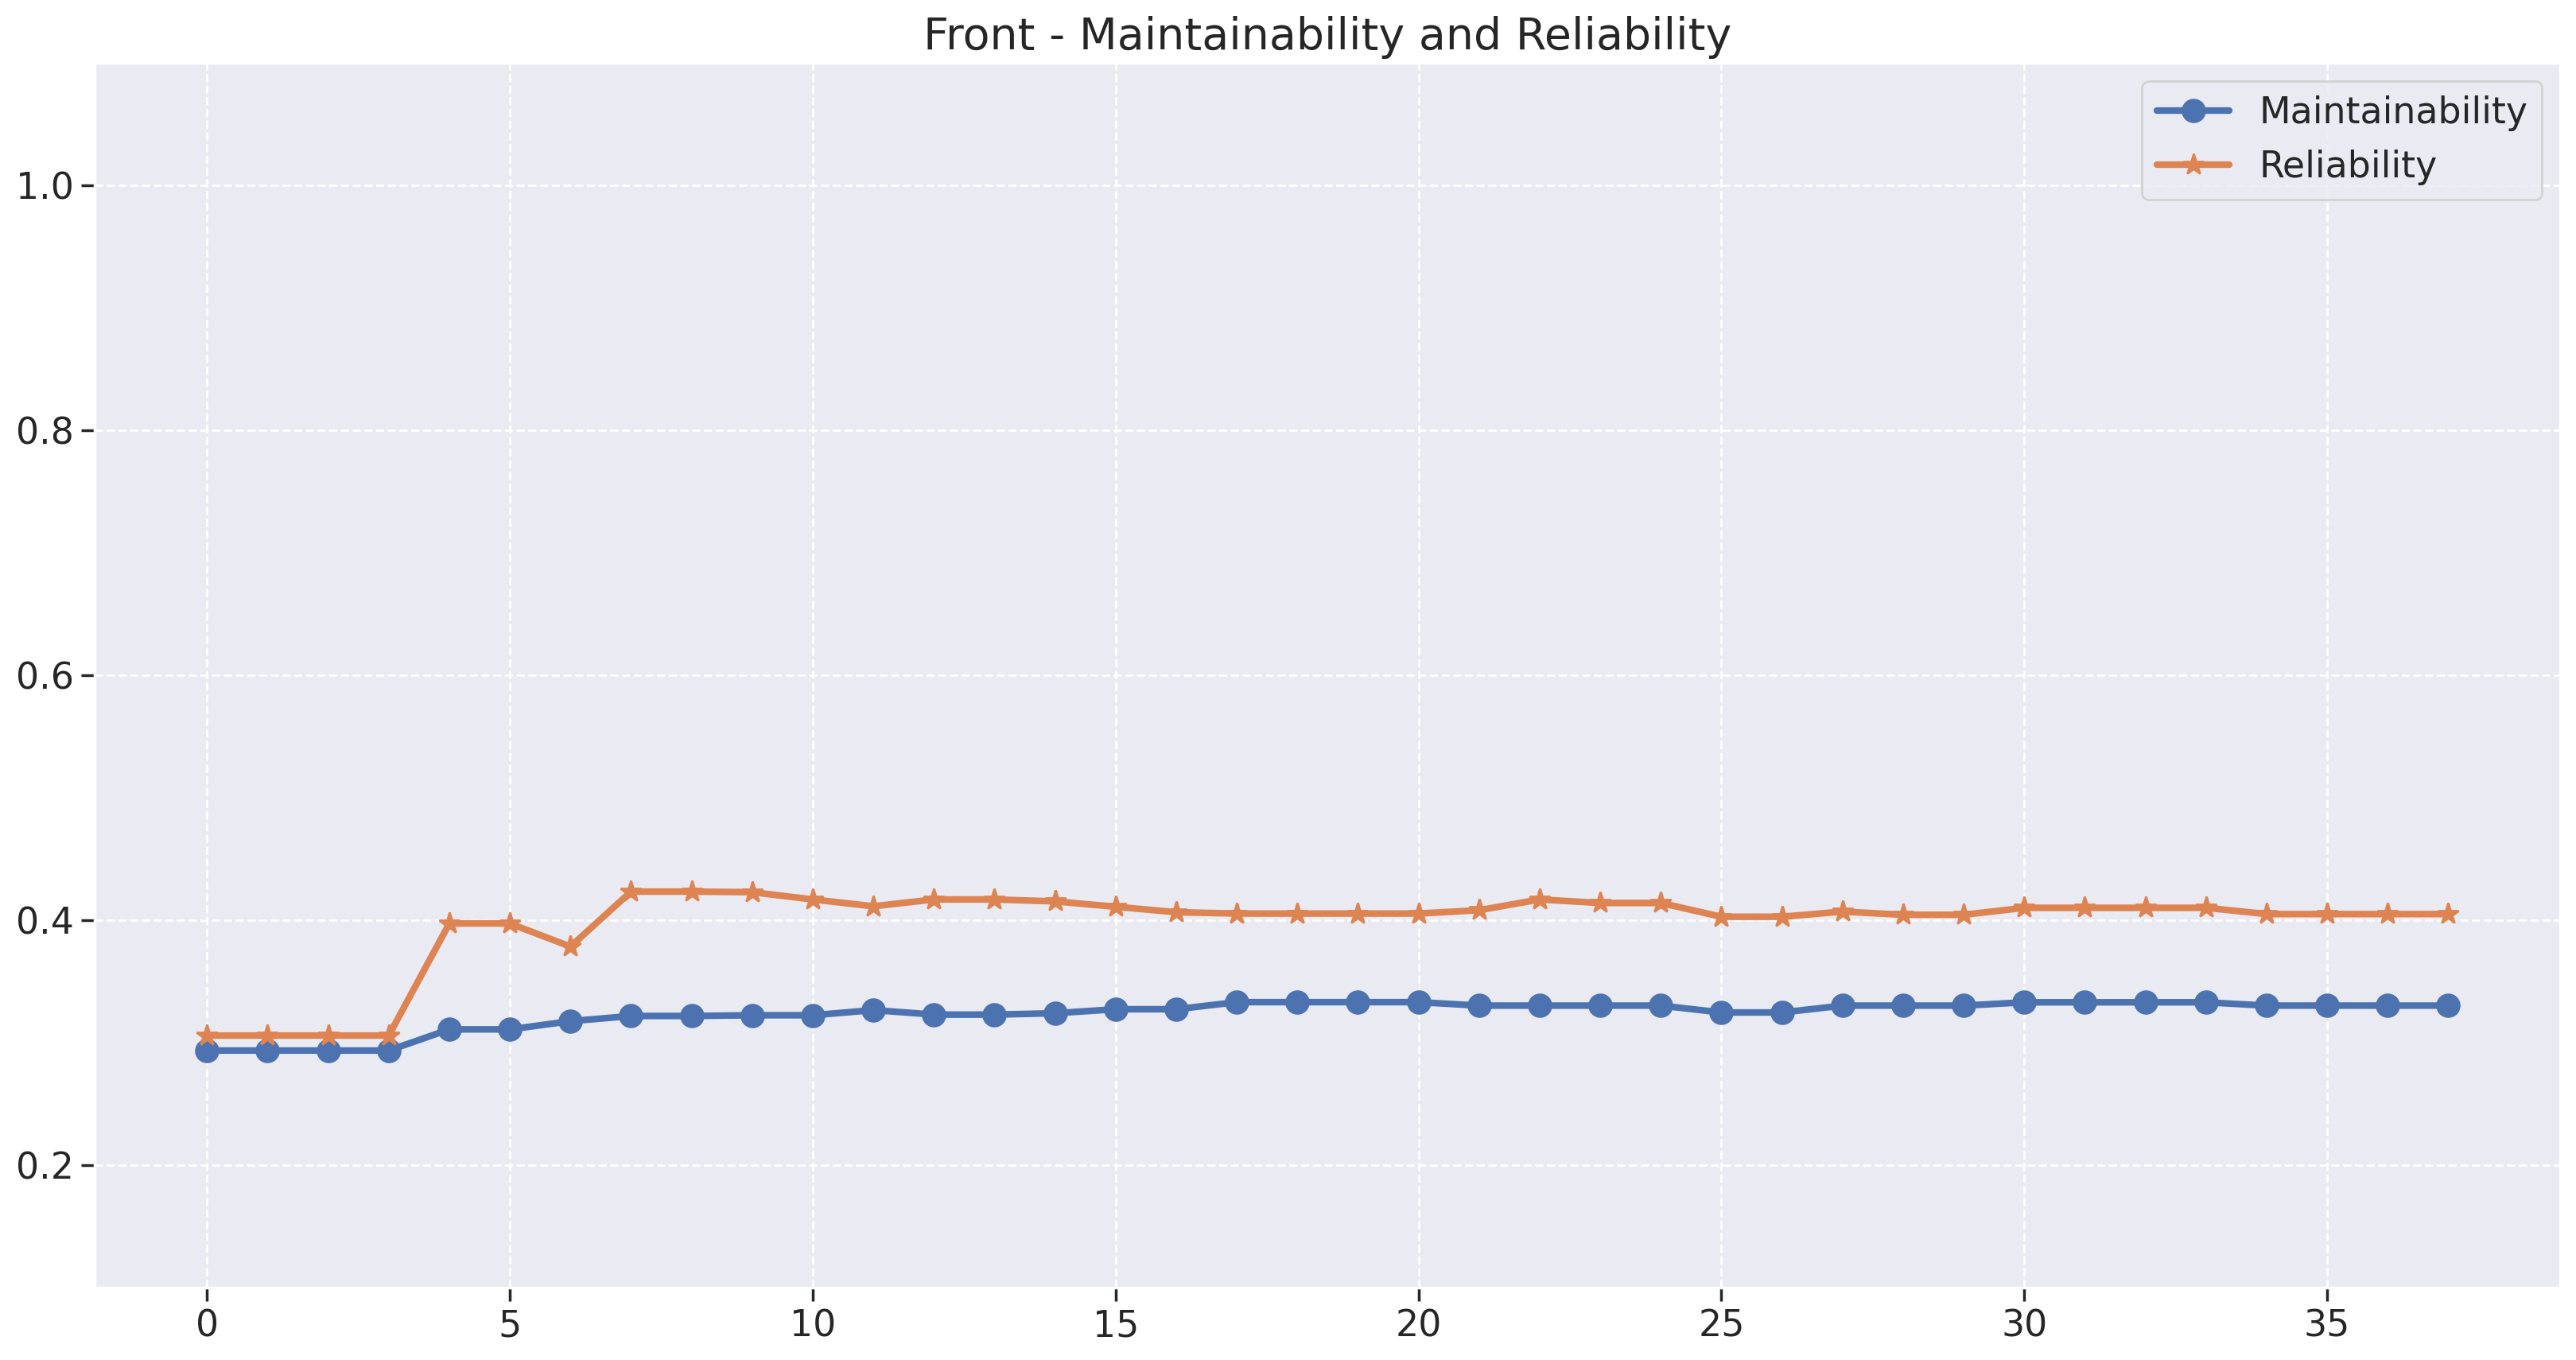

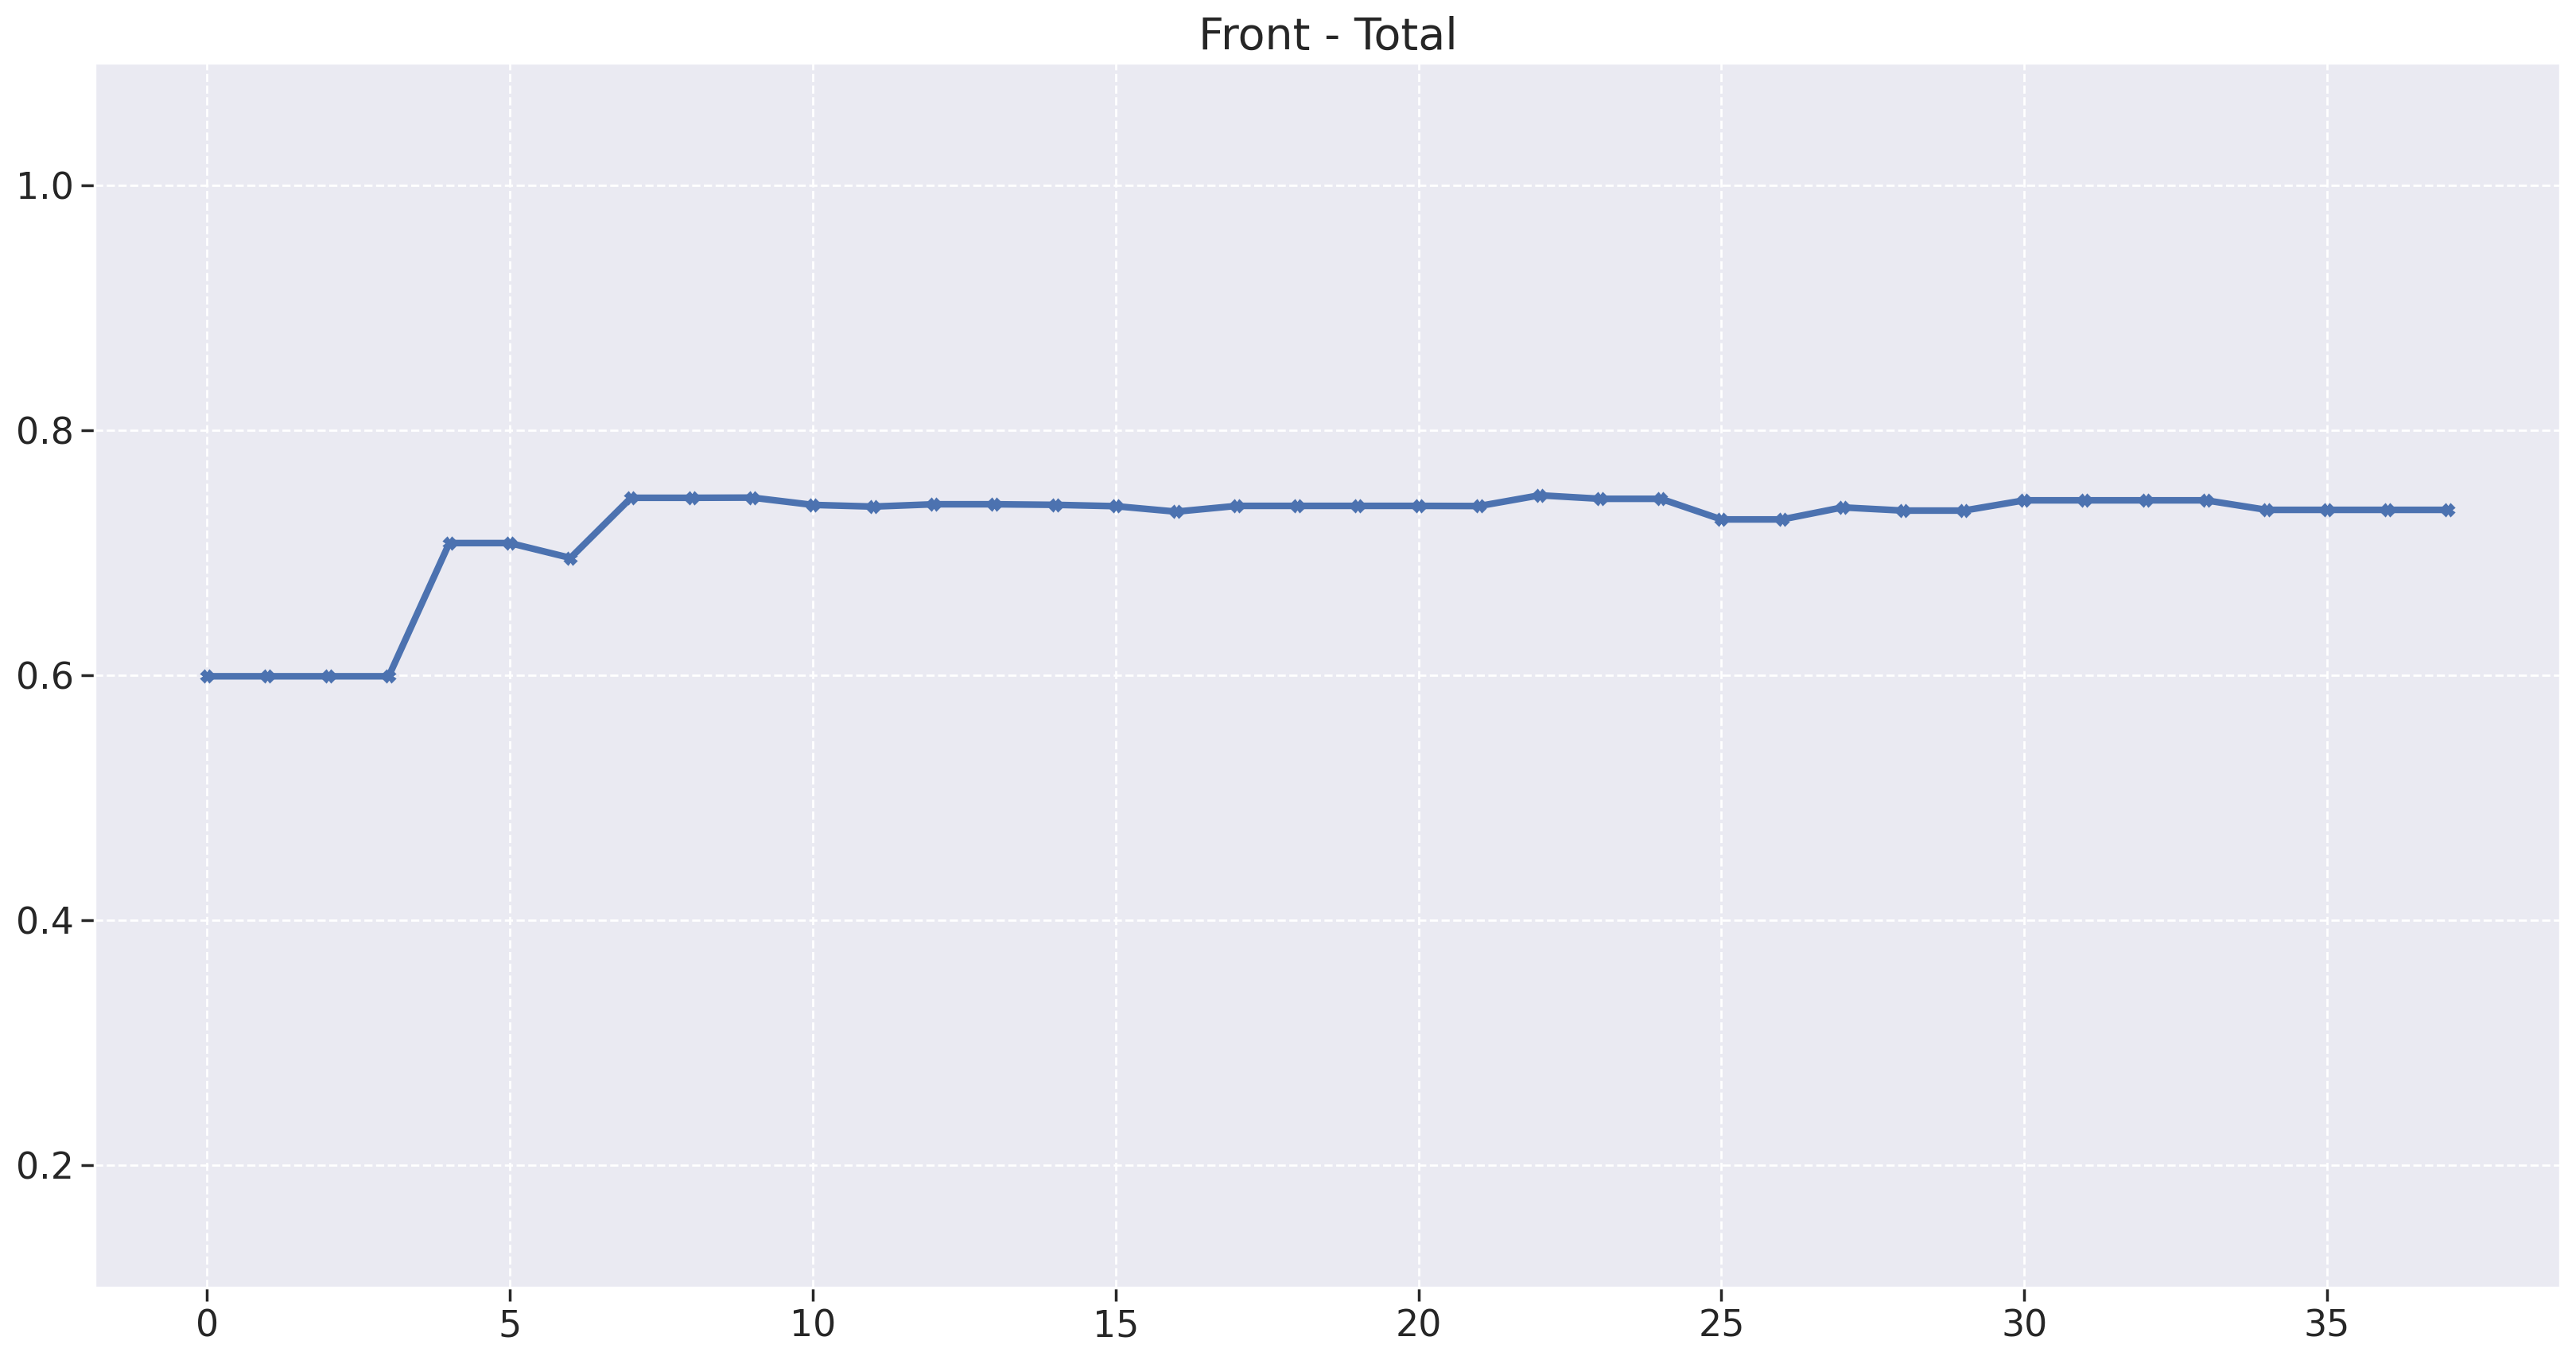

UserService
Maintainability Stats
    mean     mode   median      std      var      min      max
0.310967 0.314286 0.312437 0.006735 0.000045 0.301304 0.322826
Reliability Stats
   mean     mode   median      std      var  min      max
0.24466 0.274436 0.274436 0.086108 0.007415  0.0 0.275543
0.24466 0.275543 0.274436 0.086108 0.007415  0.0 0.275543


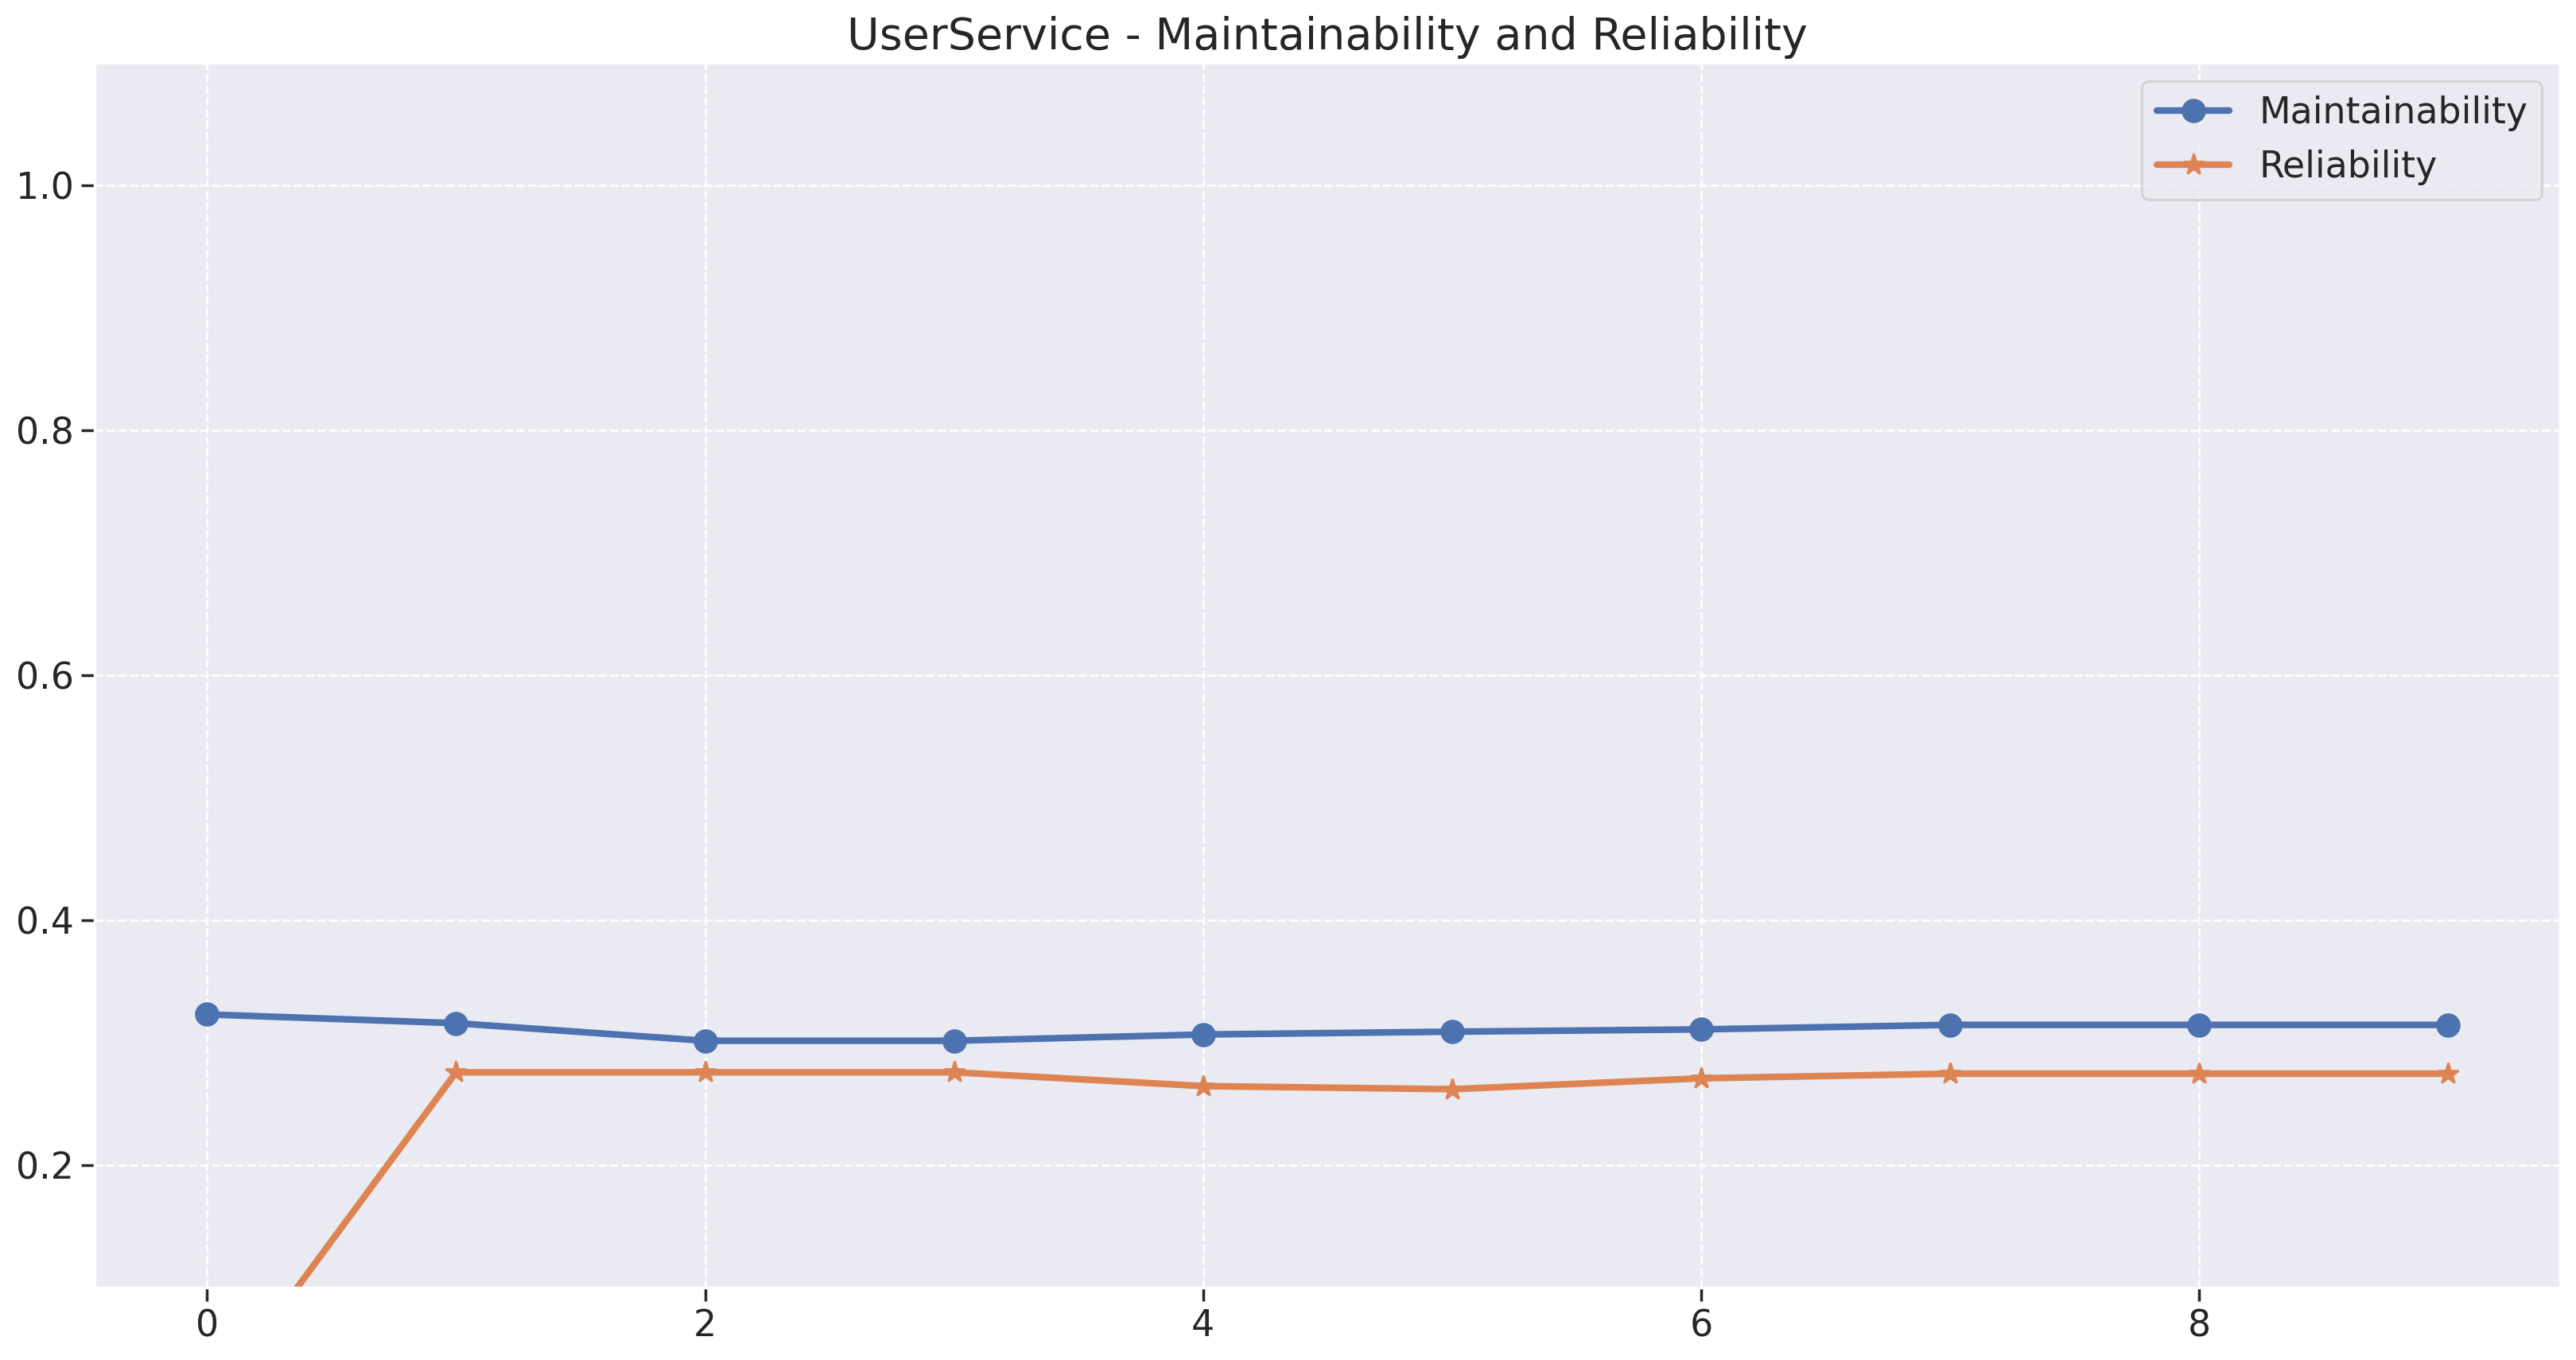

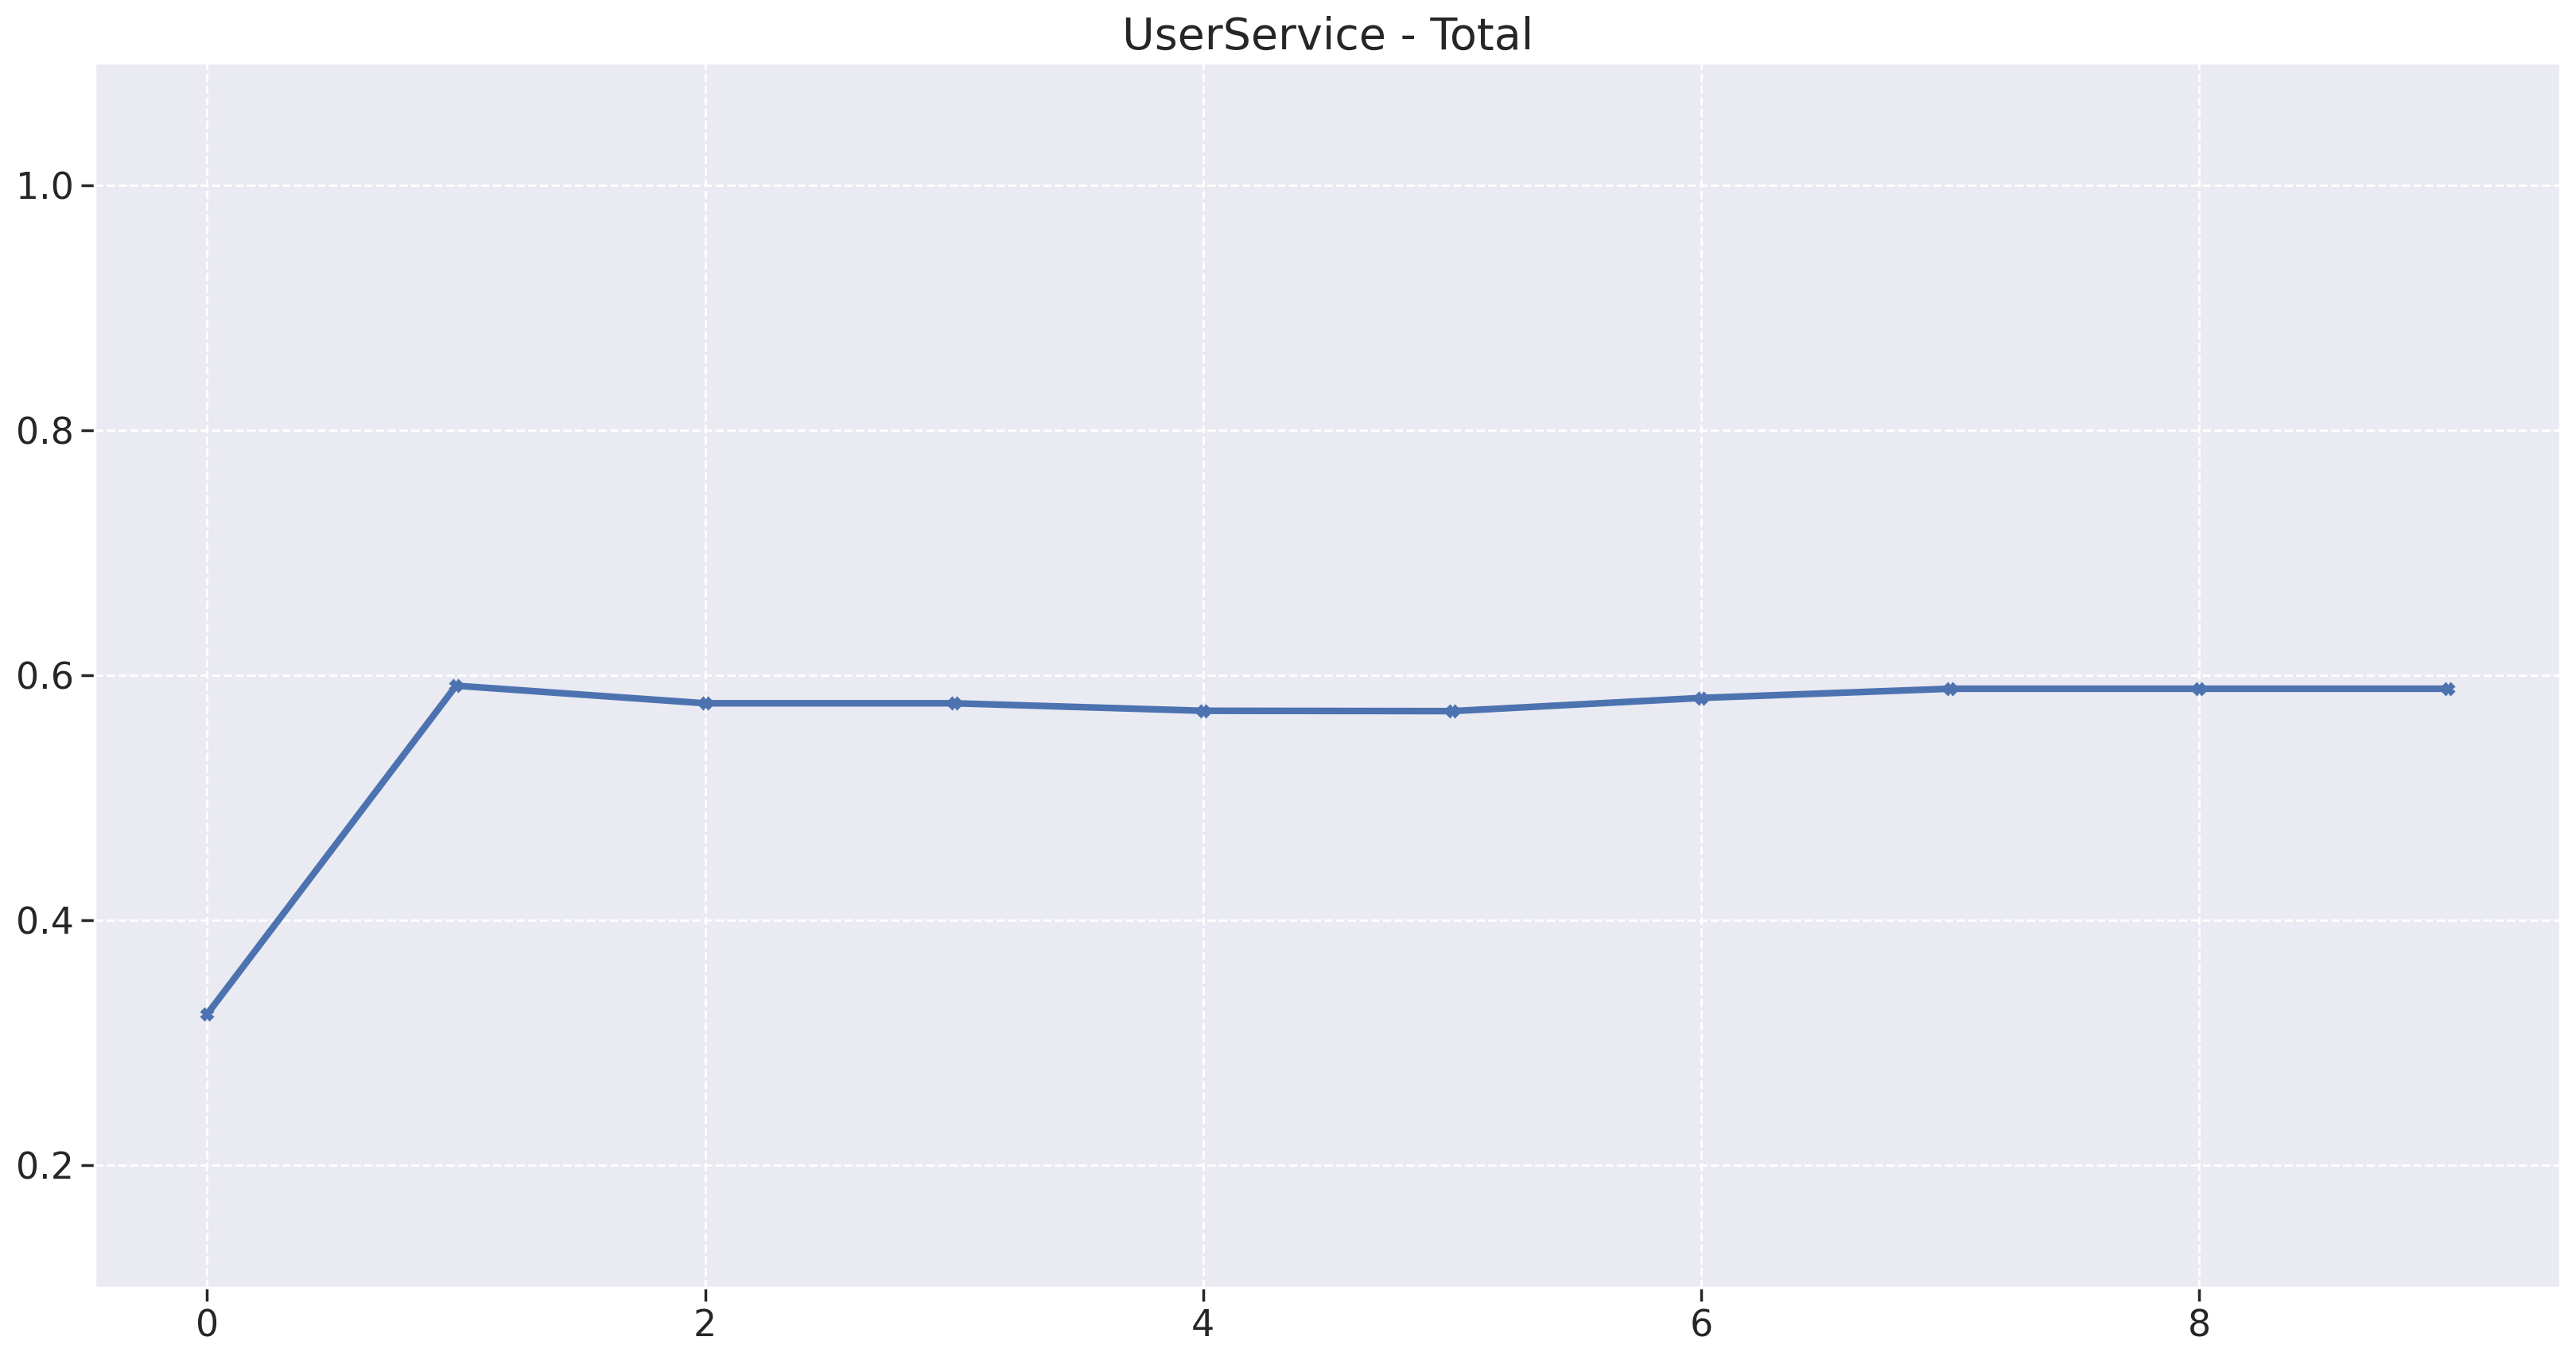

ClassroomService
Maintainability Stats
    mean  mode  median      std      var      min  max
0.317858 0.325   0.325 0.012591 0.000159 0.295263 0.33
Reliability Stats
   mean     mode   median      std      var      min      max
0.19653 0.270833 0.255952 0.107877 0.011637 0.019231 0.270833


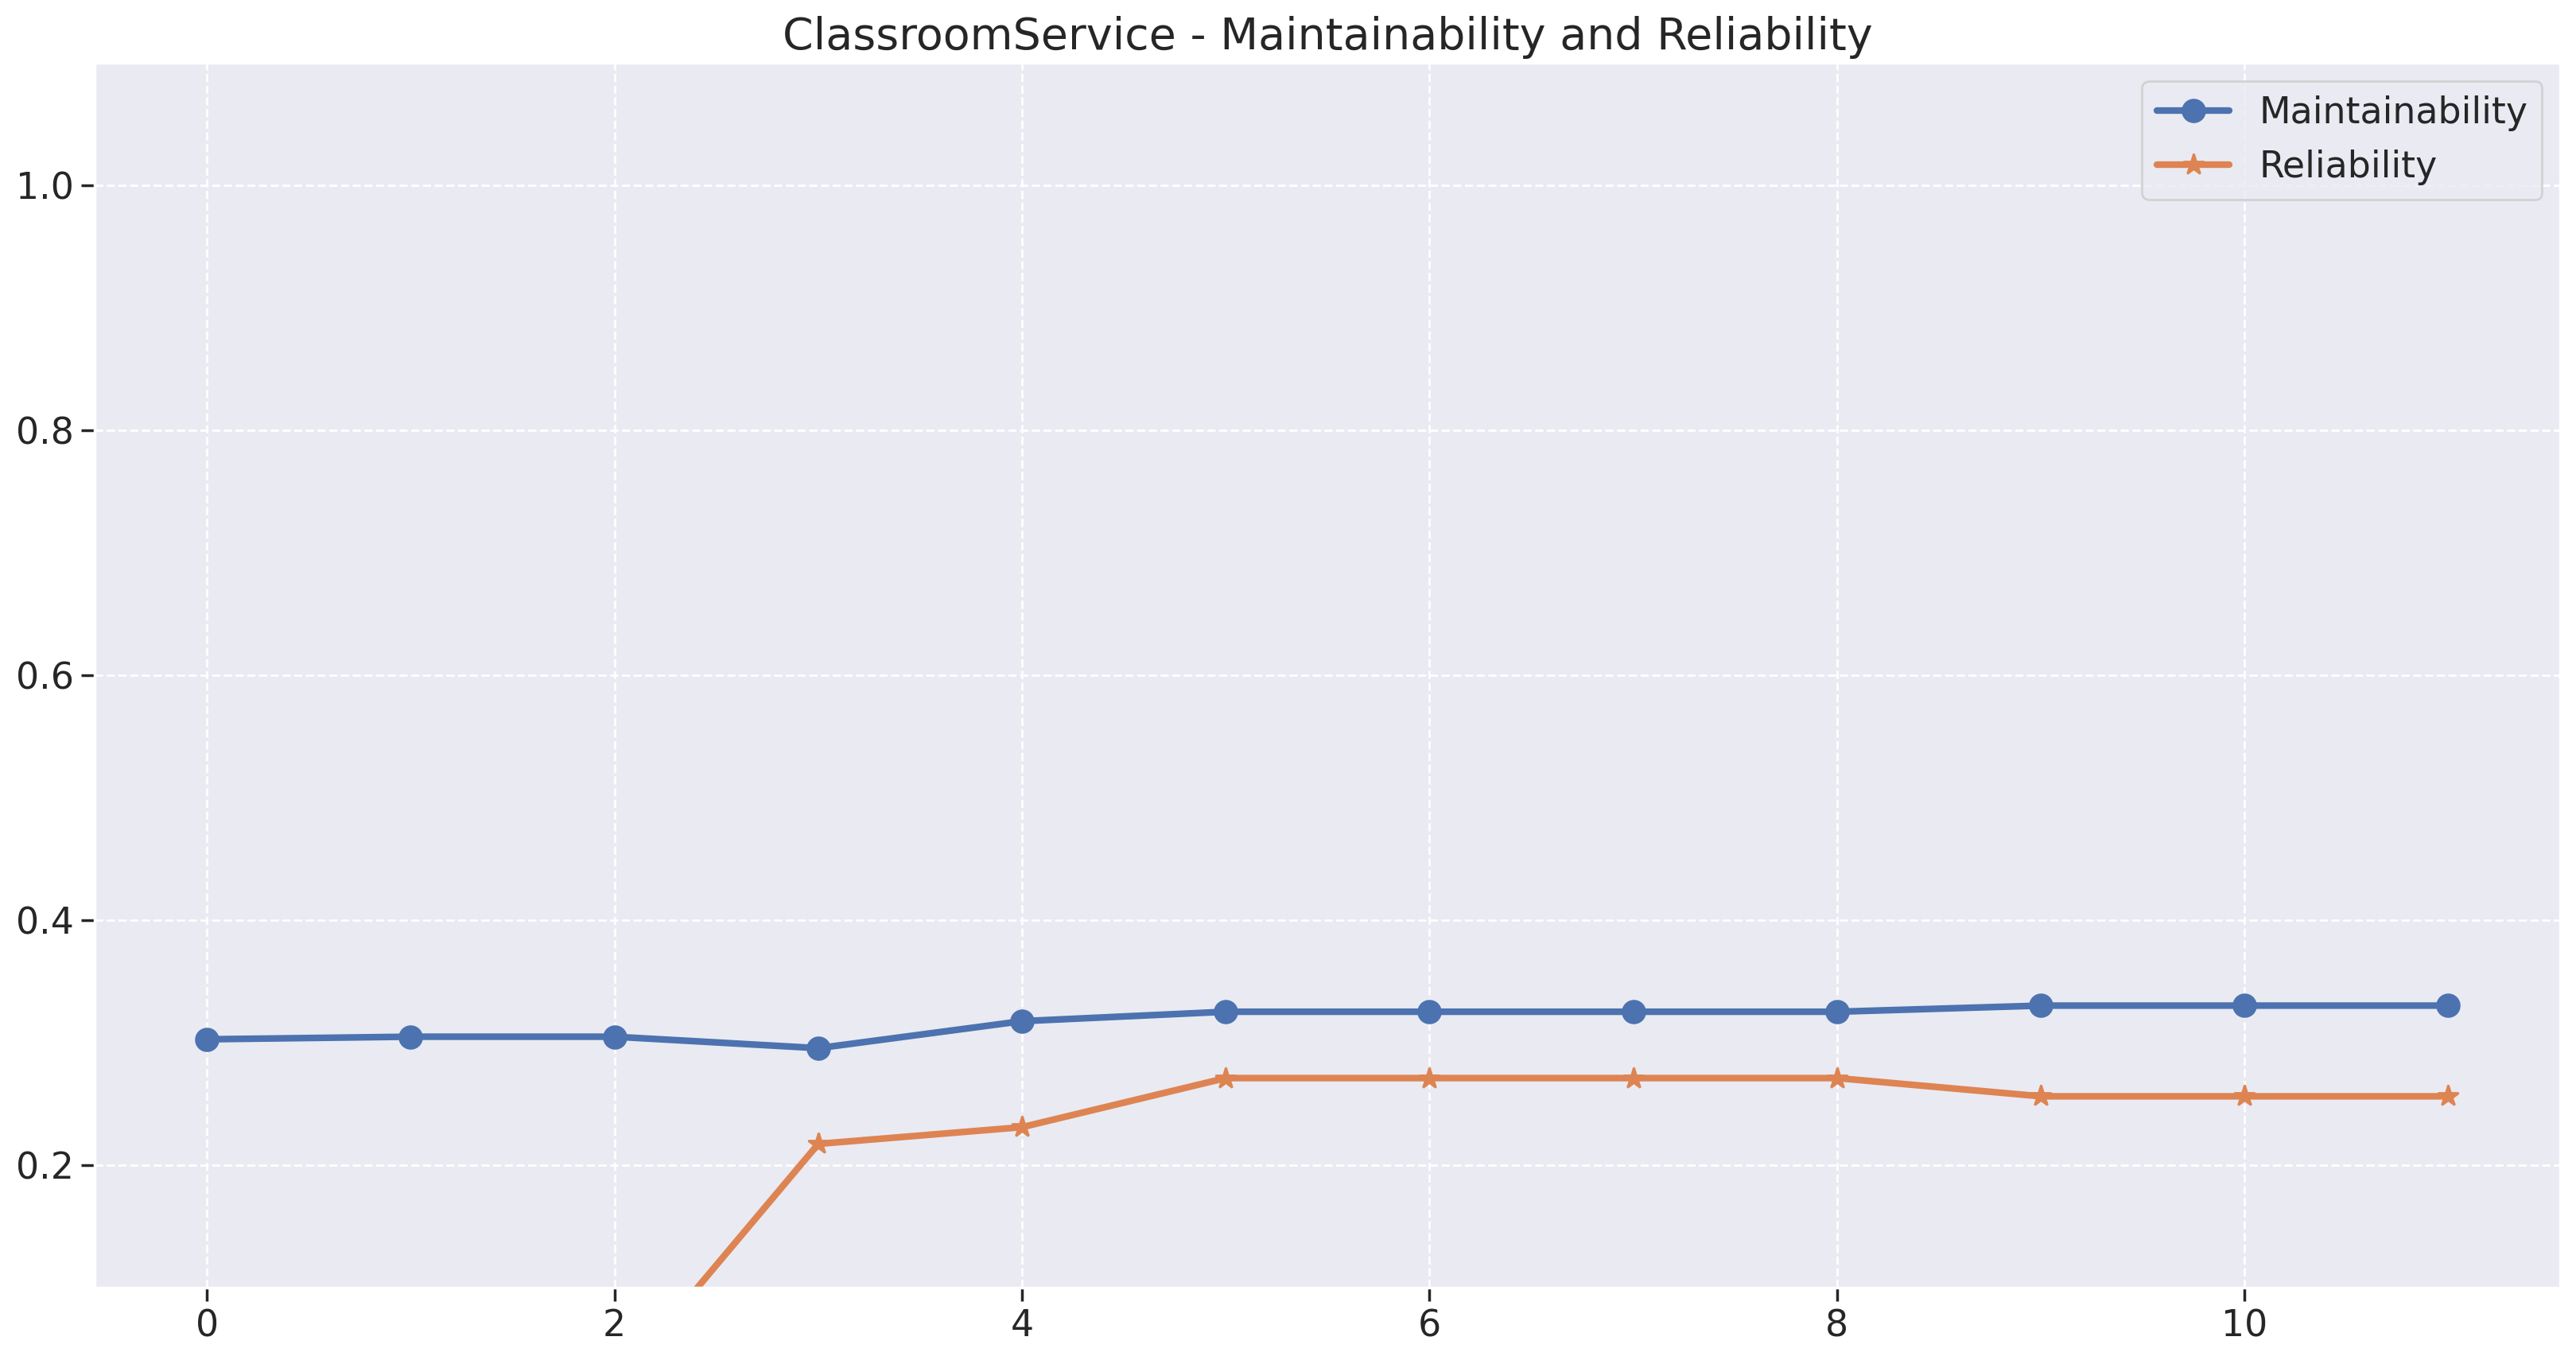

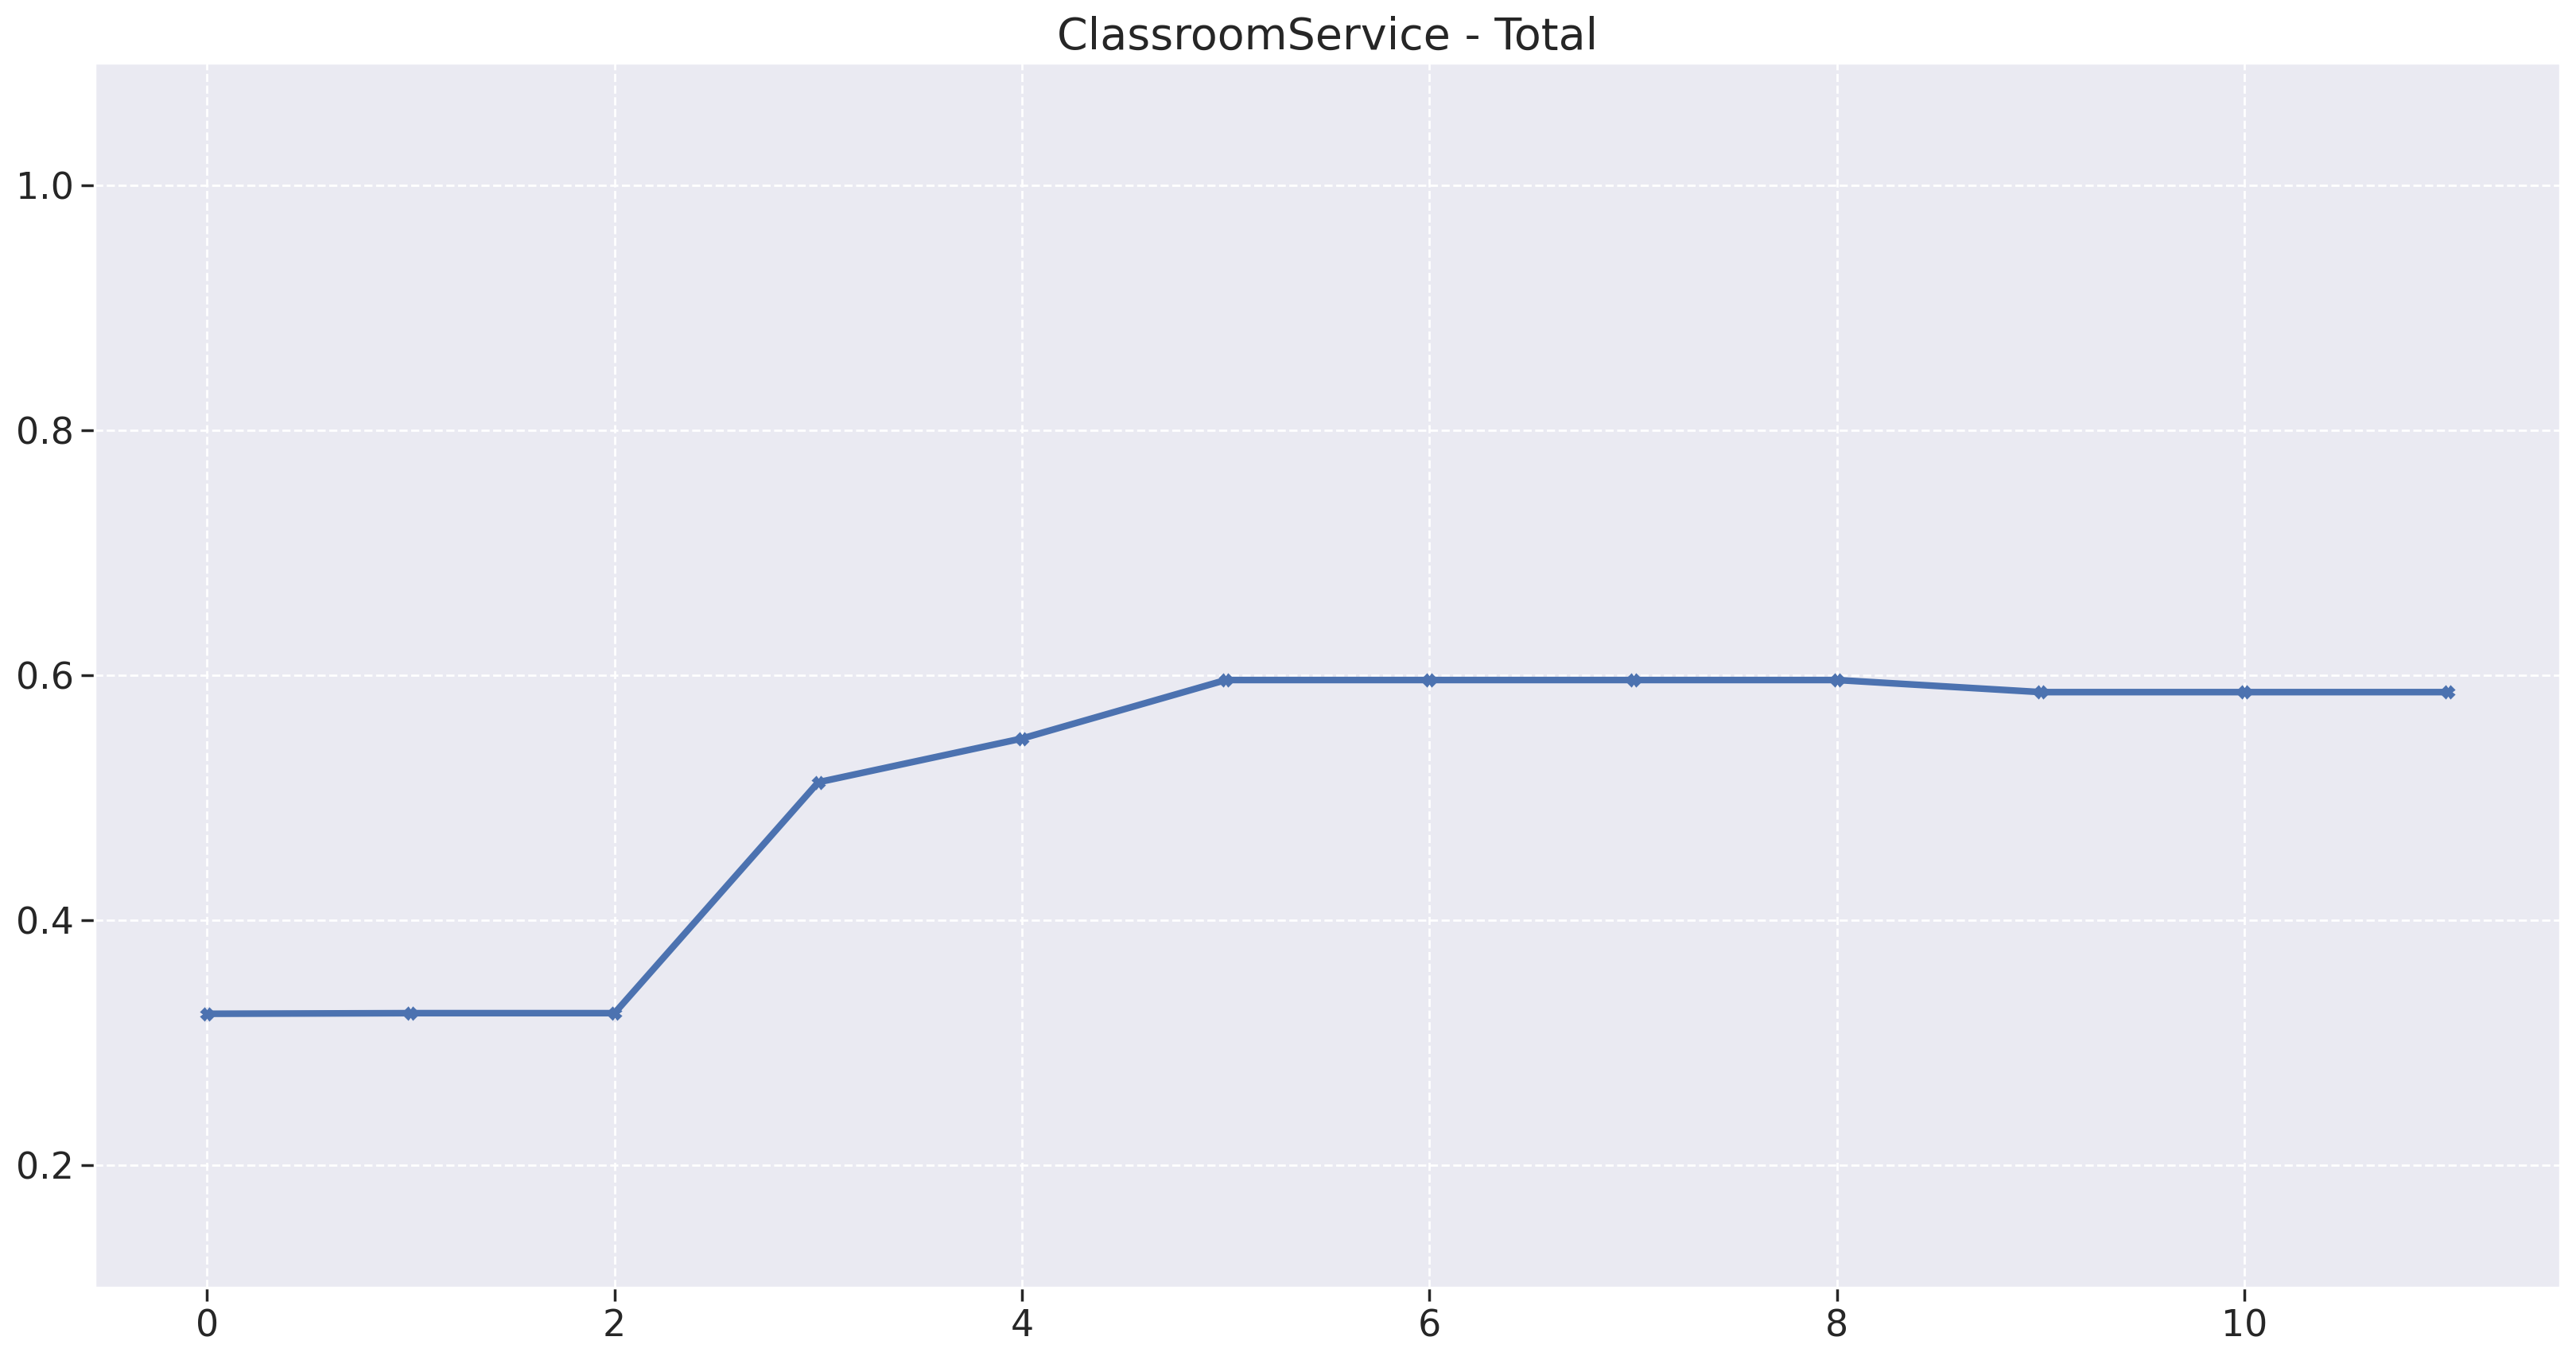

ProductionService
Maintainability Stats
   mean   mode  median      std      var  min    max
0.33396 0.3366  0.3366 0.003615 0.000013 0.33 0.3366
Reliability Stats
    mean     mode   median      std      var      min      max
0.175274 0.146875 0.169643 0.039713 0.001577 0.146875 0.243333
0.175274 0.169643 0.169643 0.039713 0.001577 0.146875 0.243333


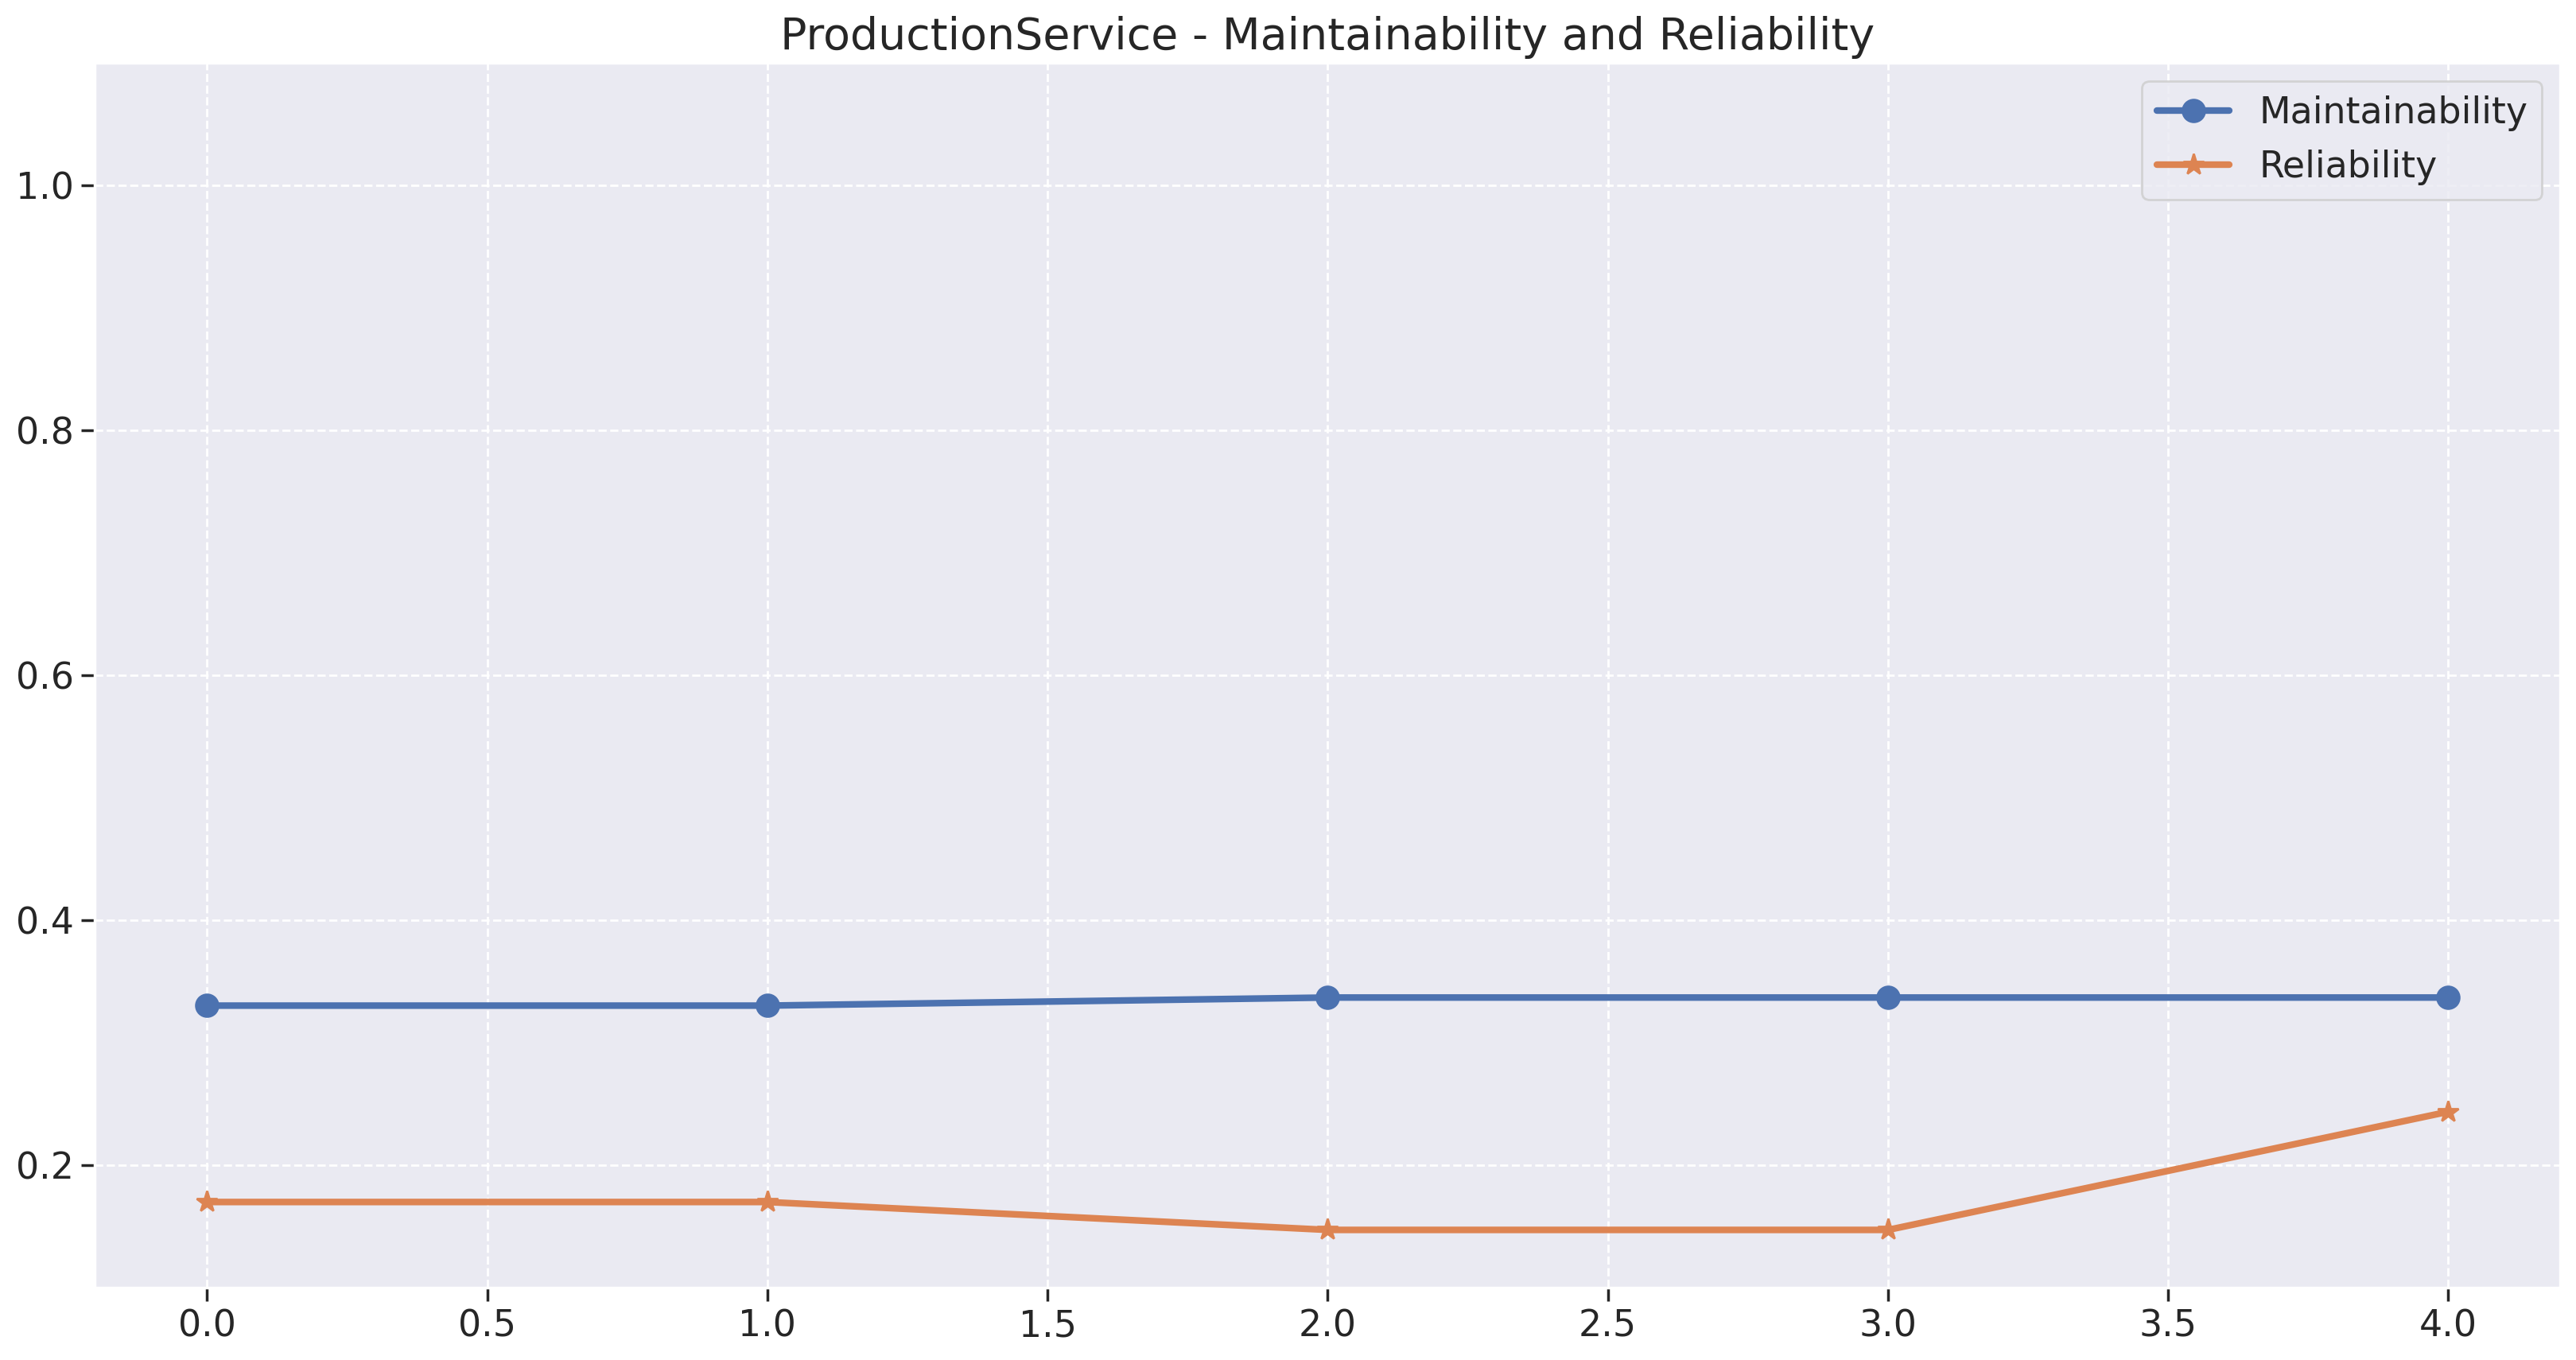

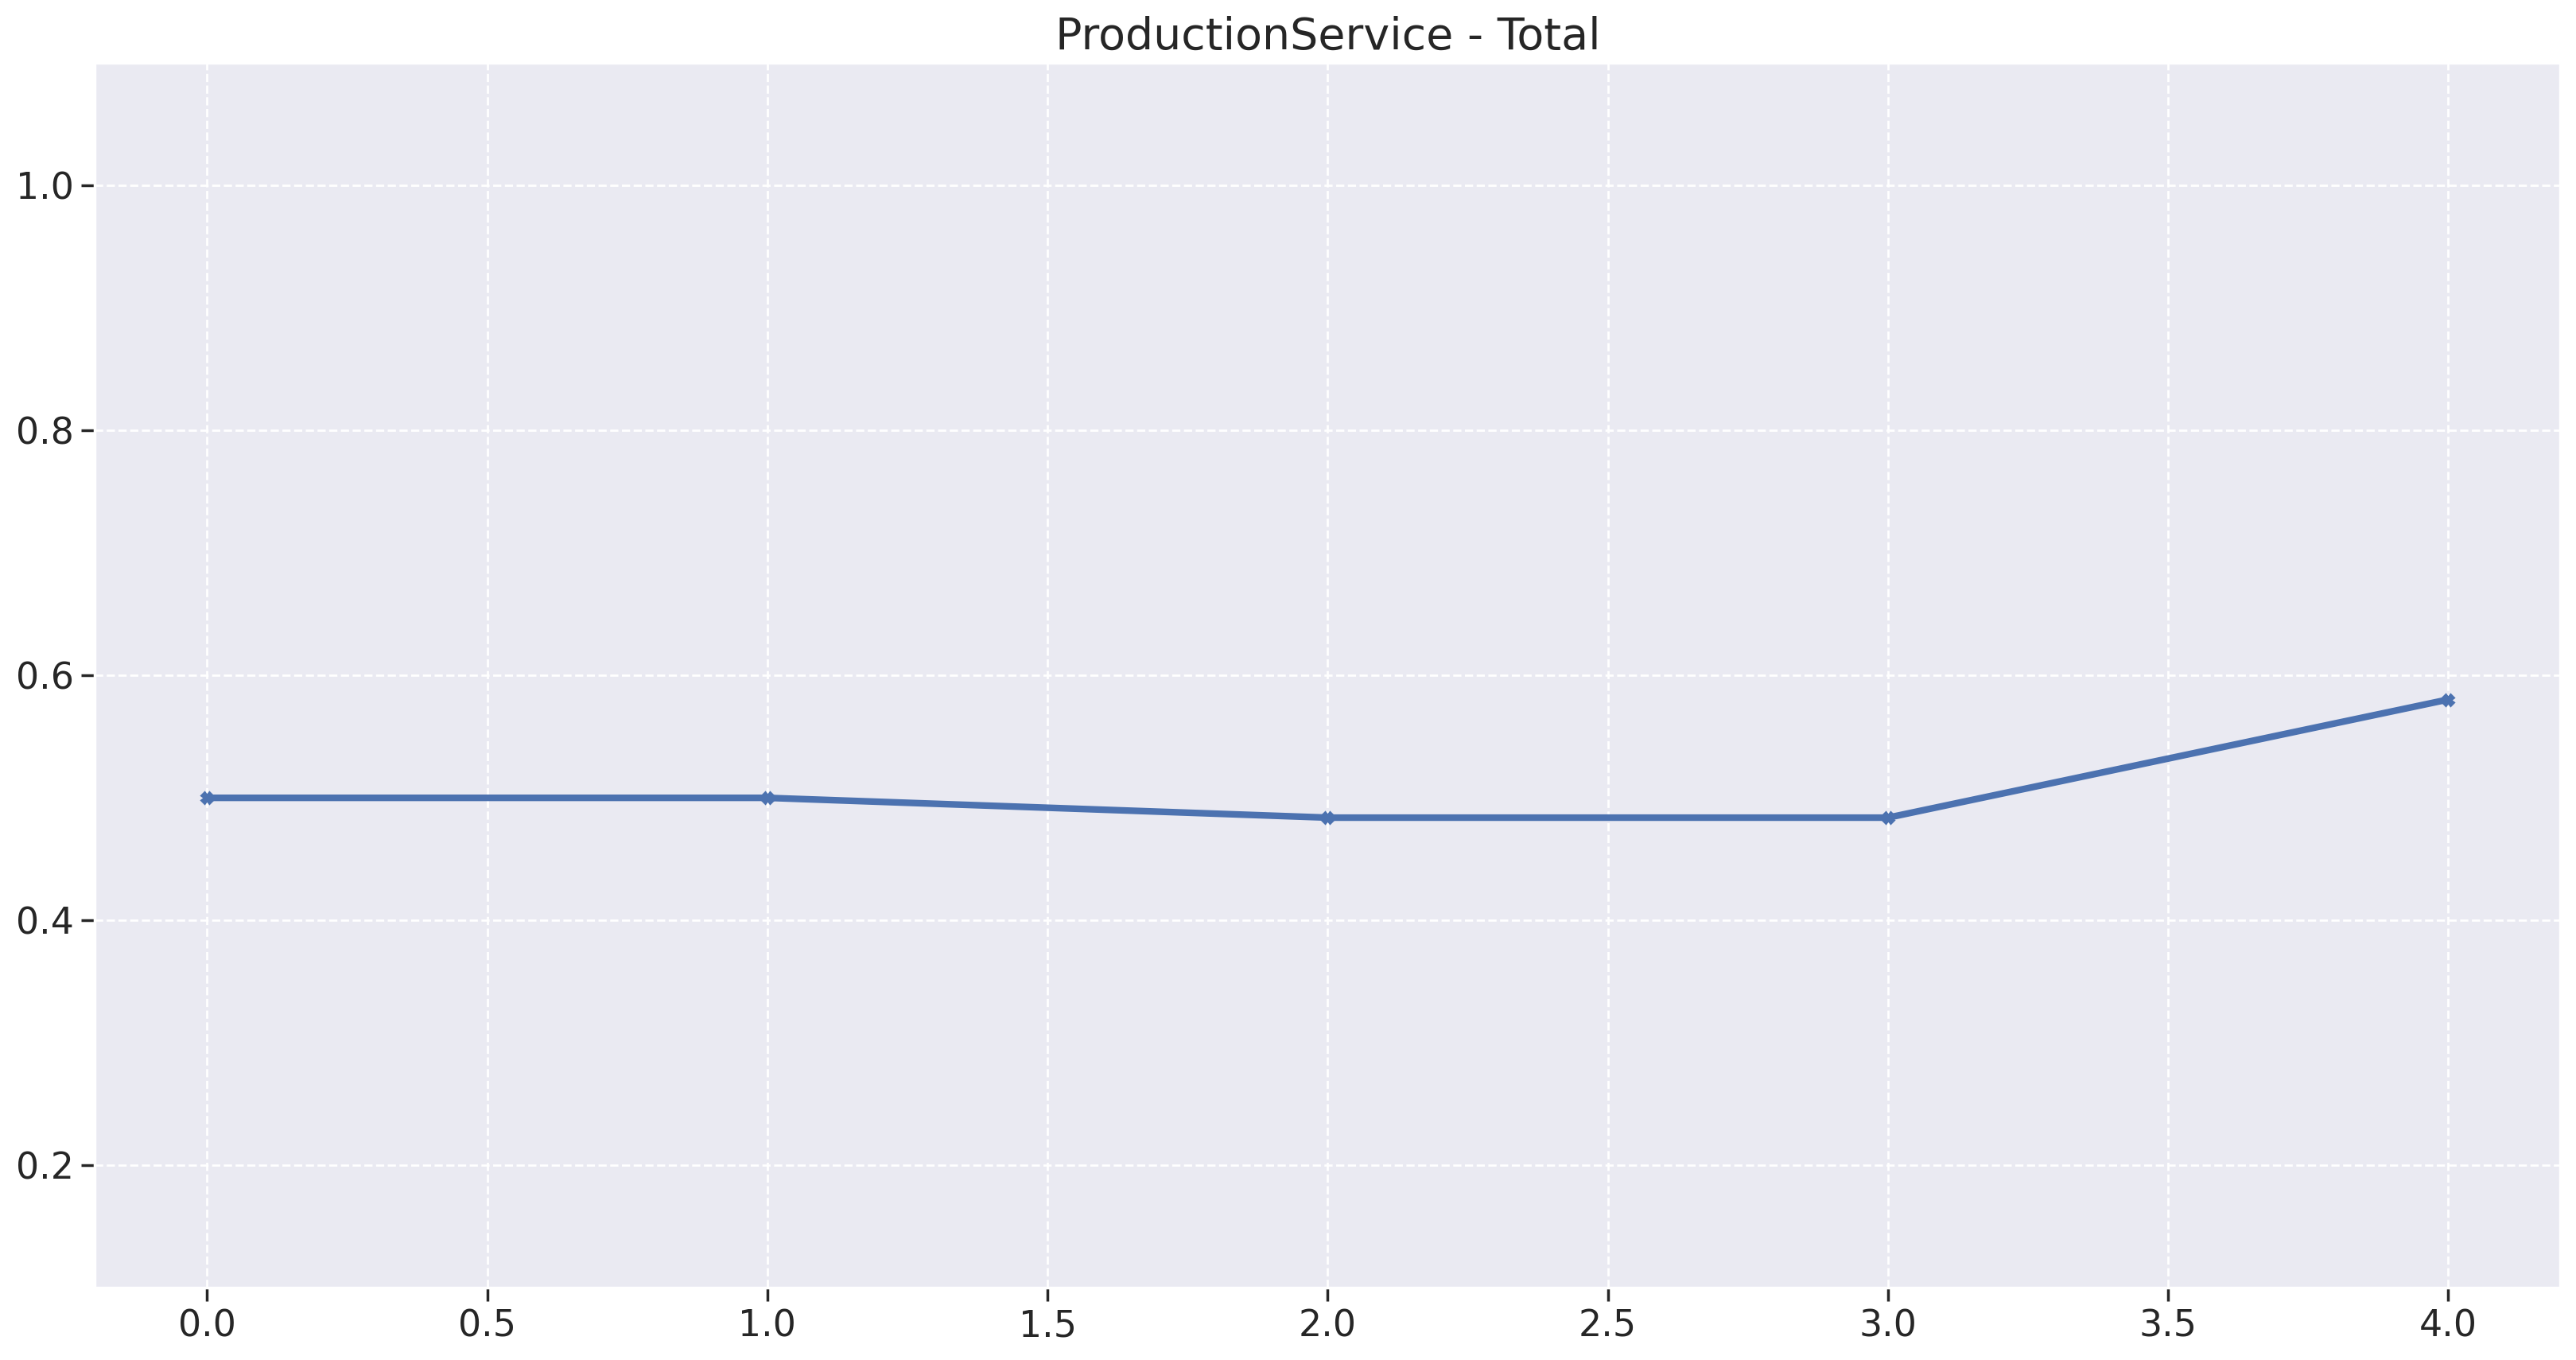

In [201]:
for name, data in metrics.items():
    print(name)
    analysis(data, name)

### Quality characteristic indicator

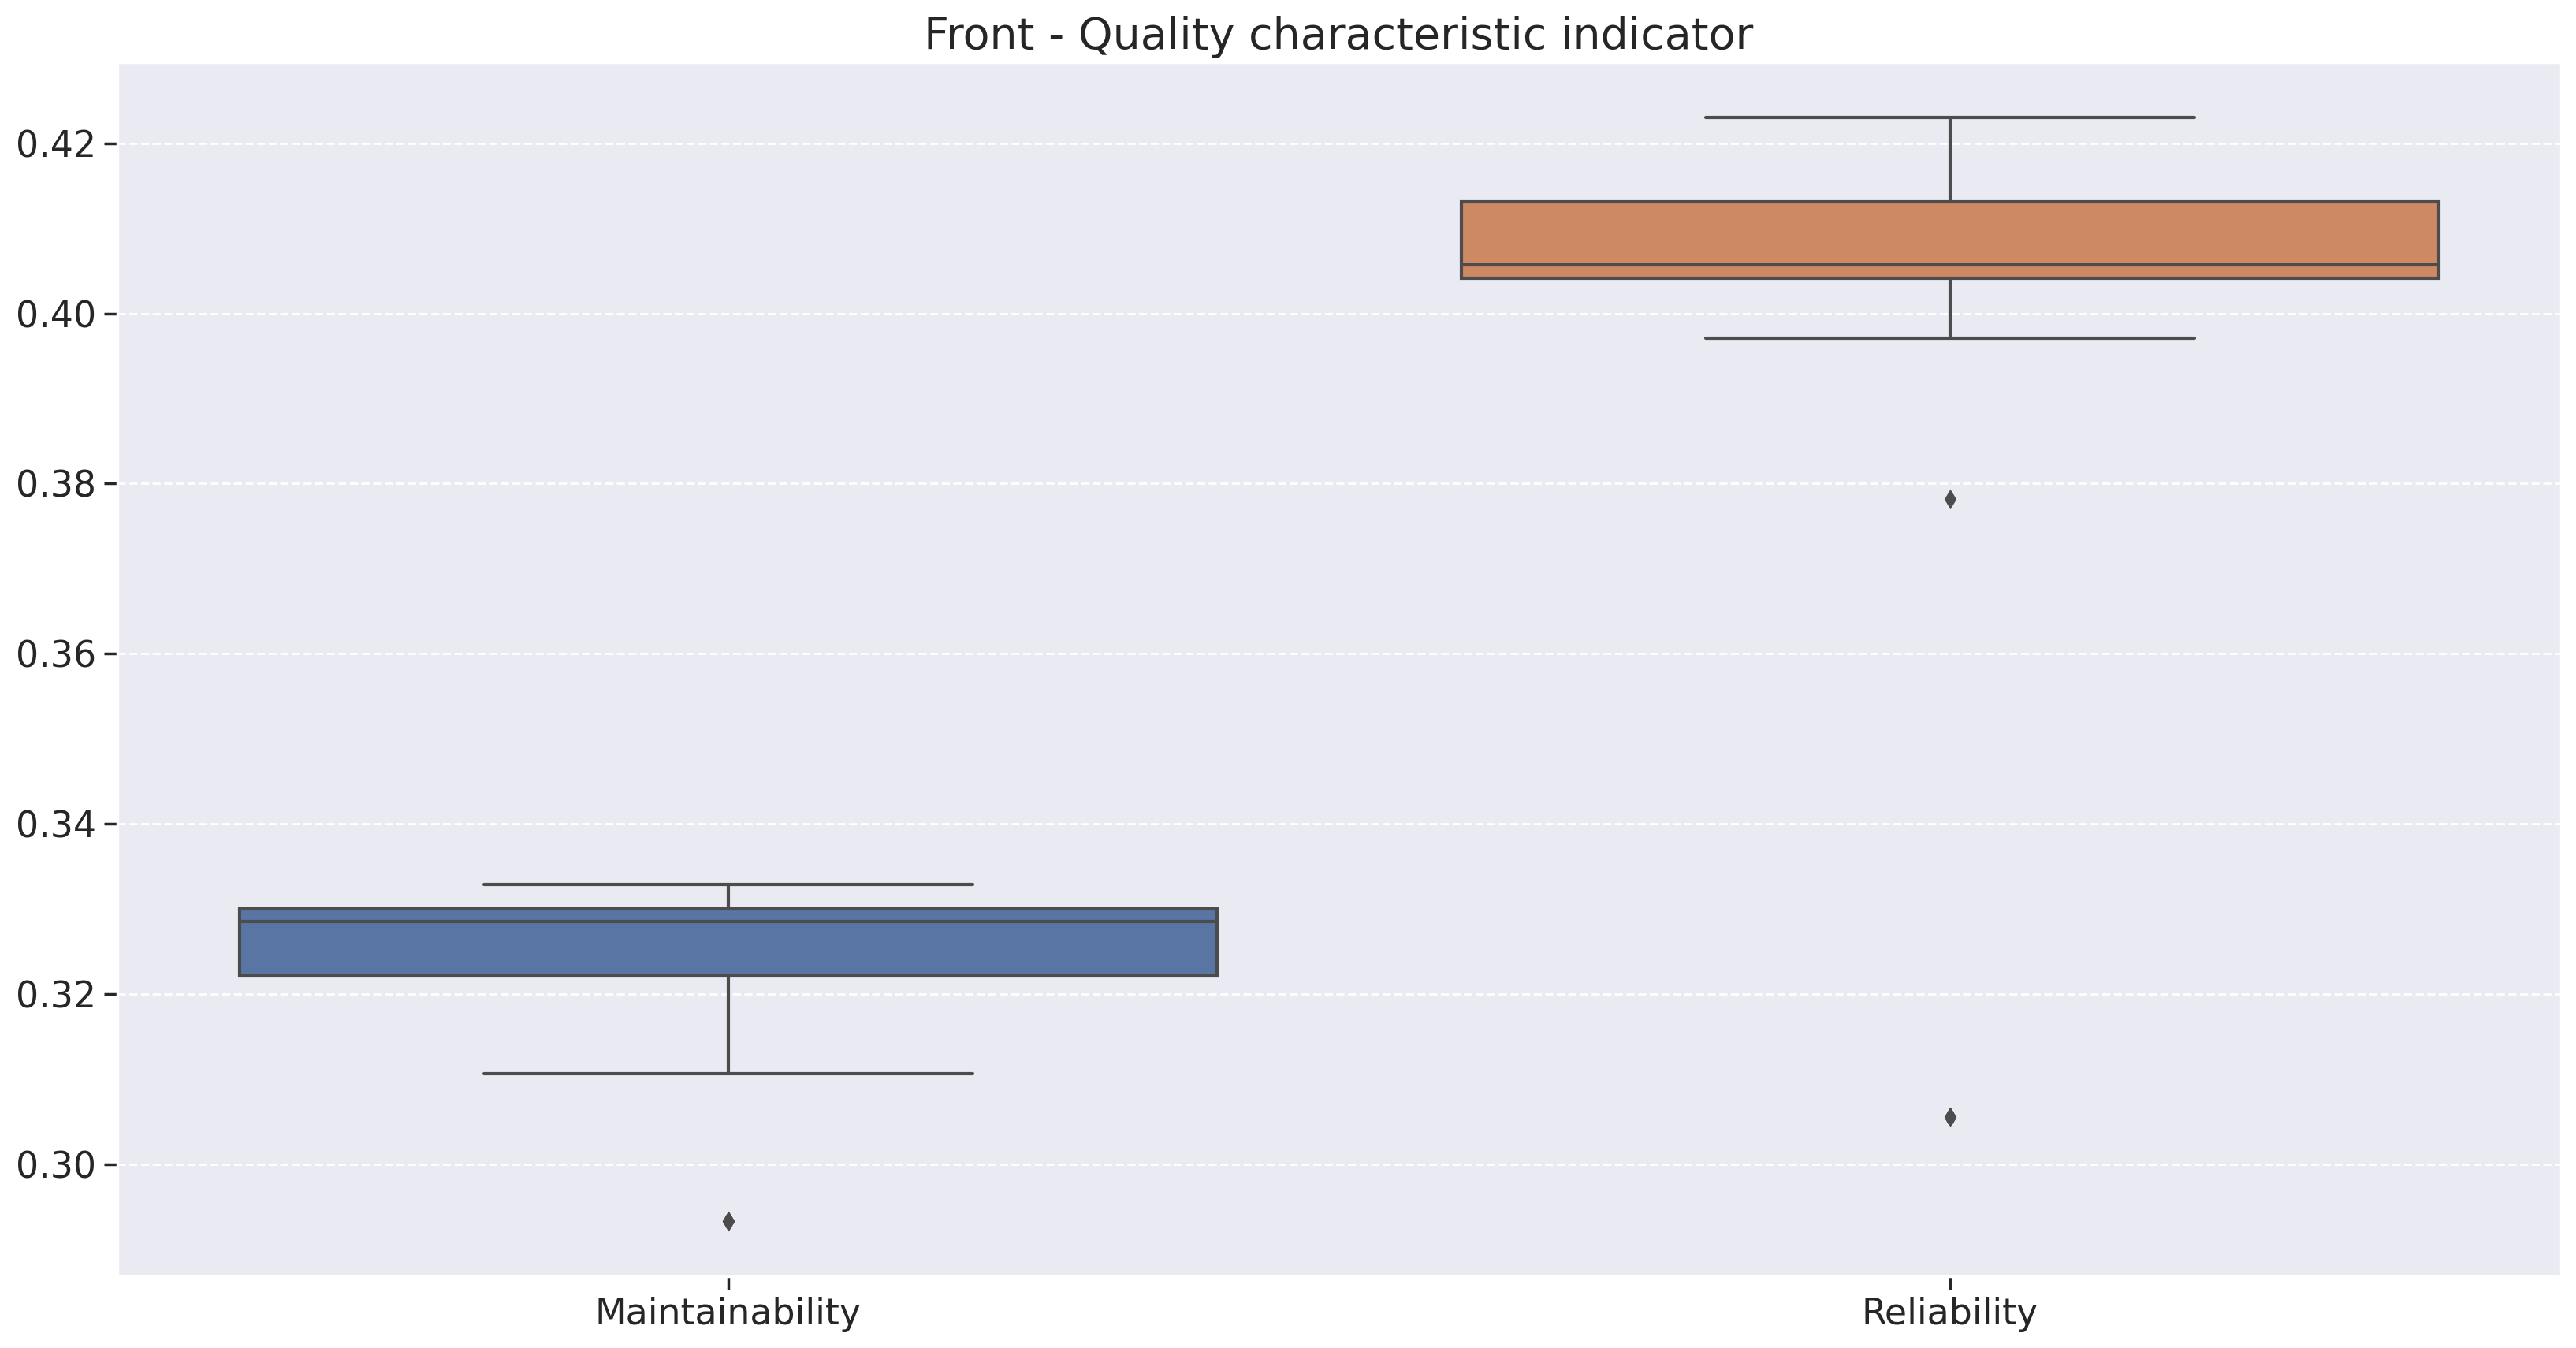

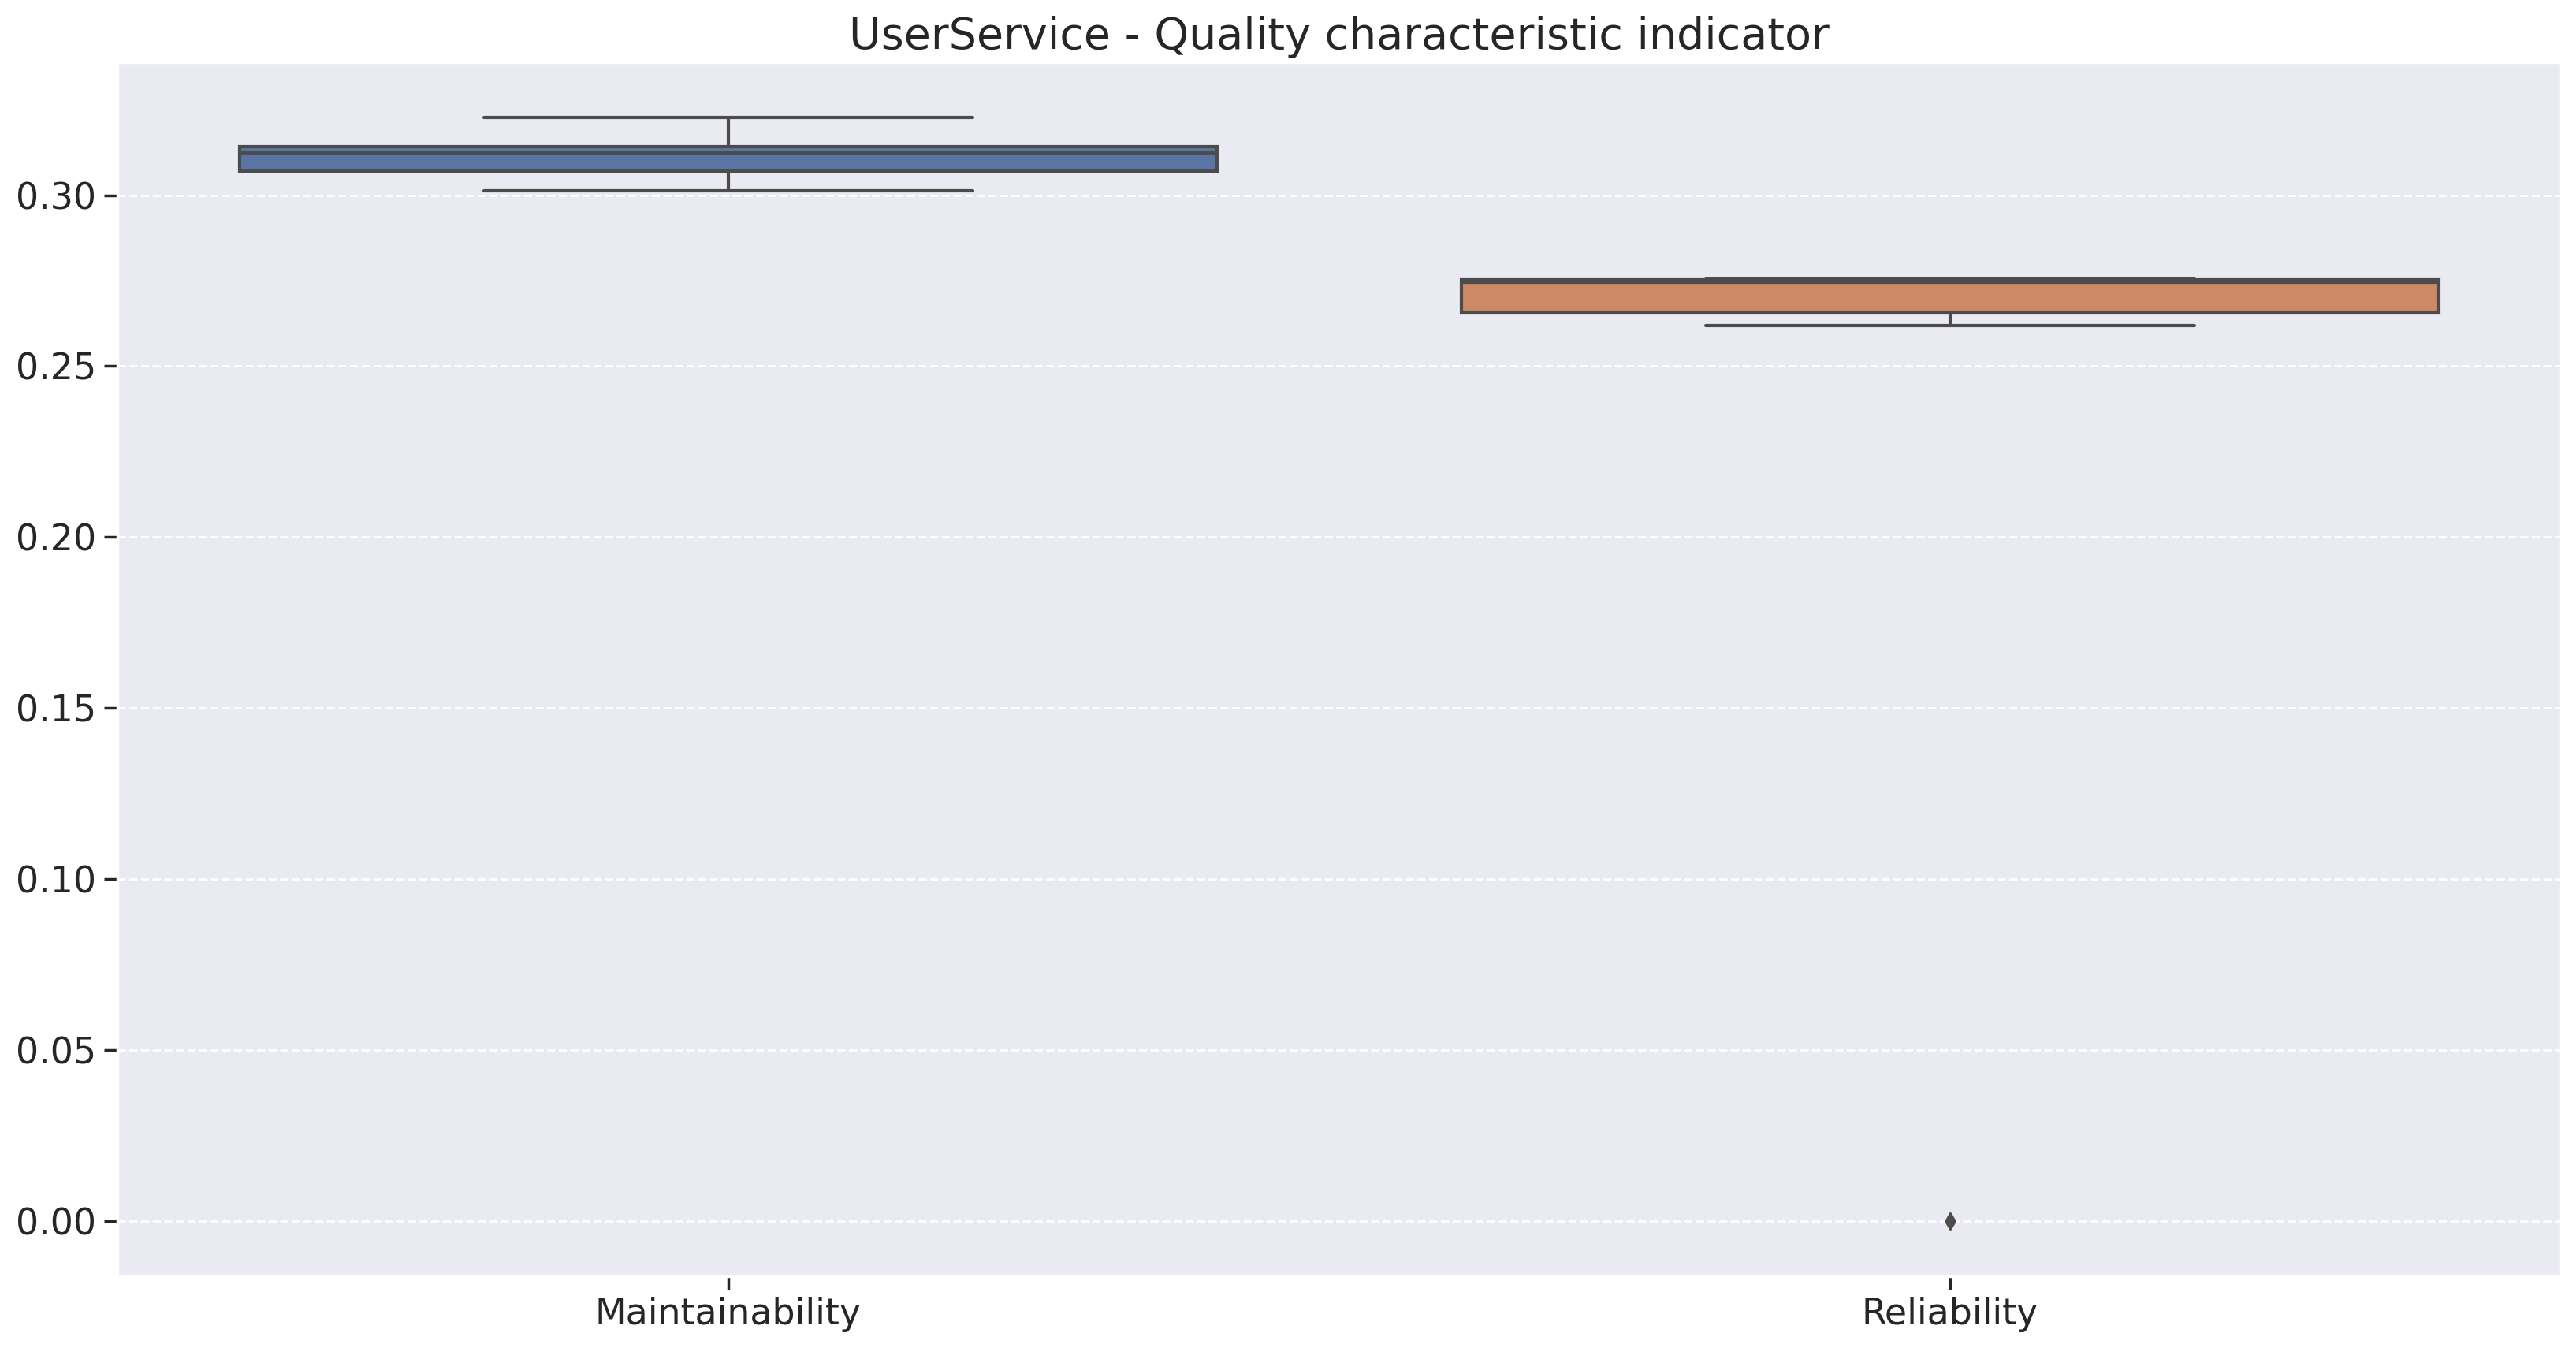

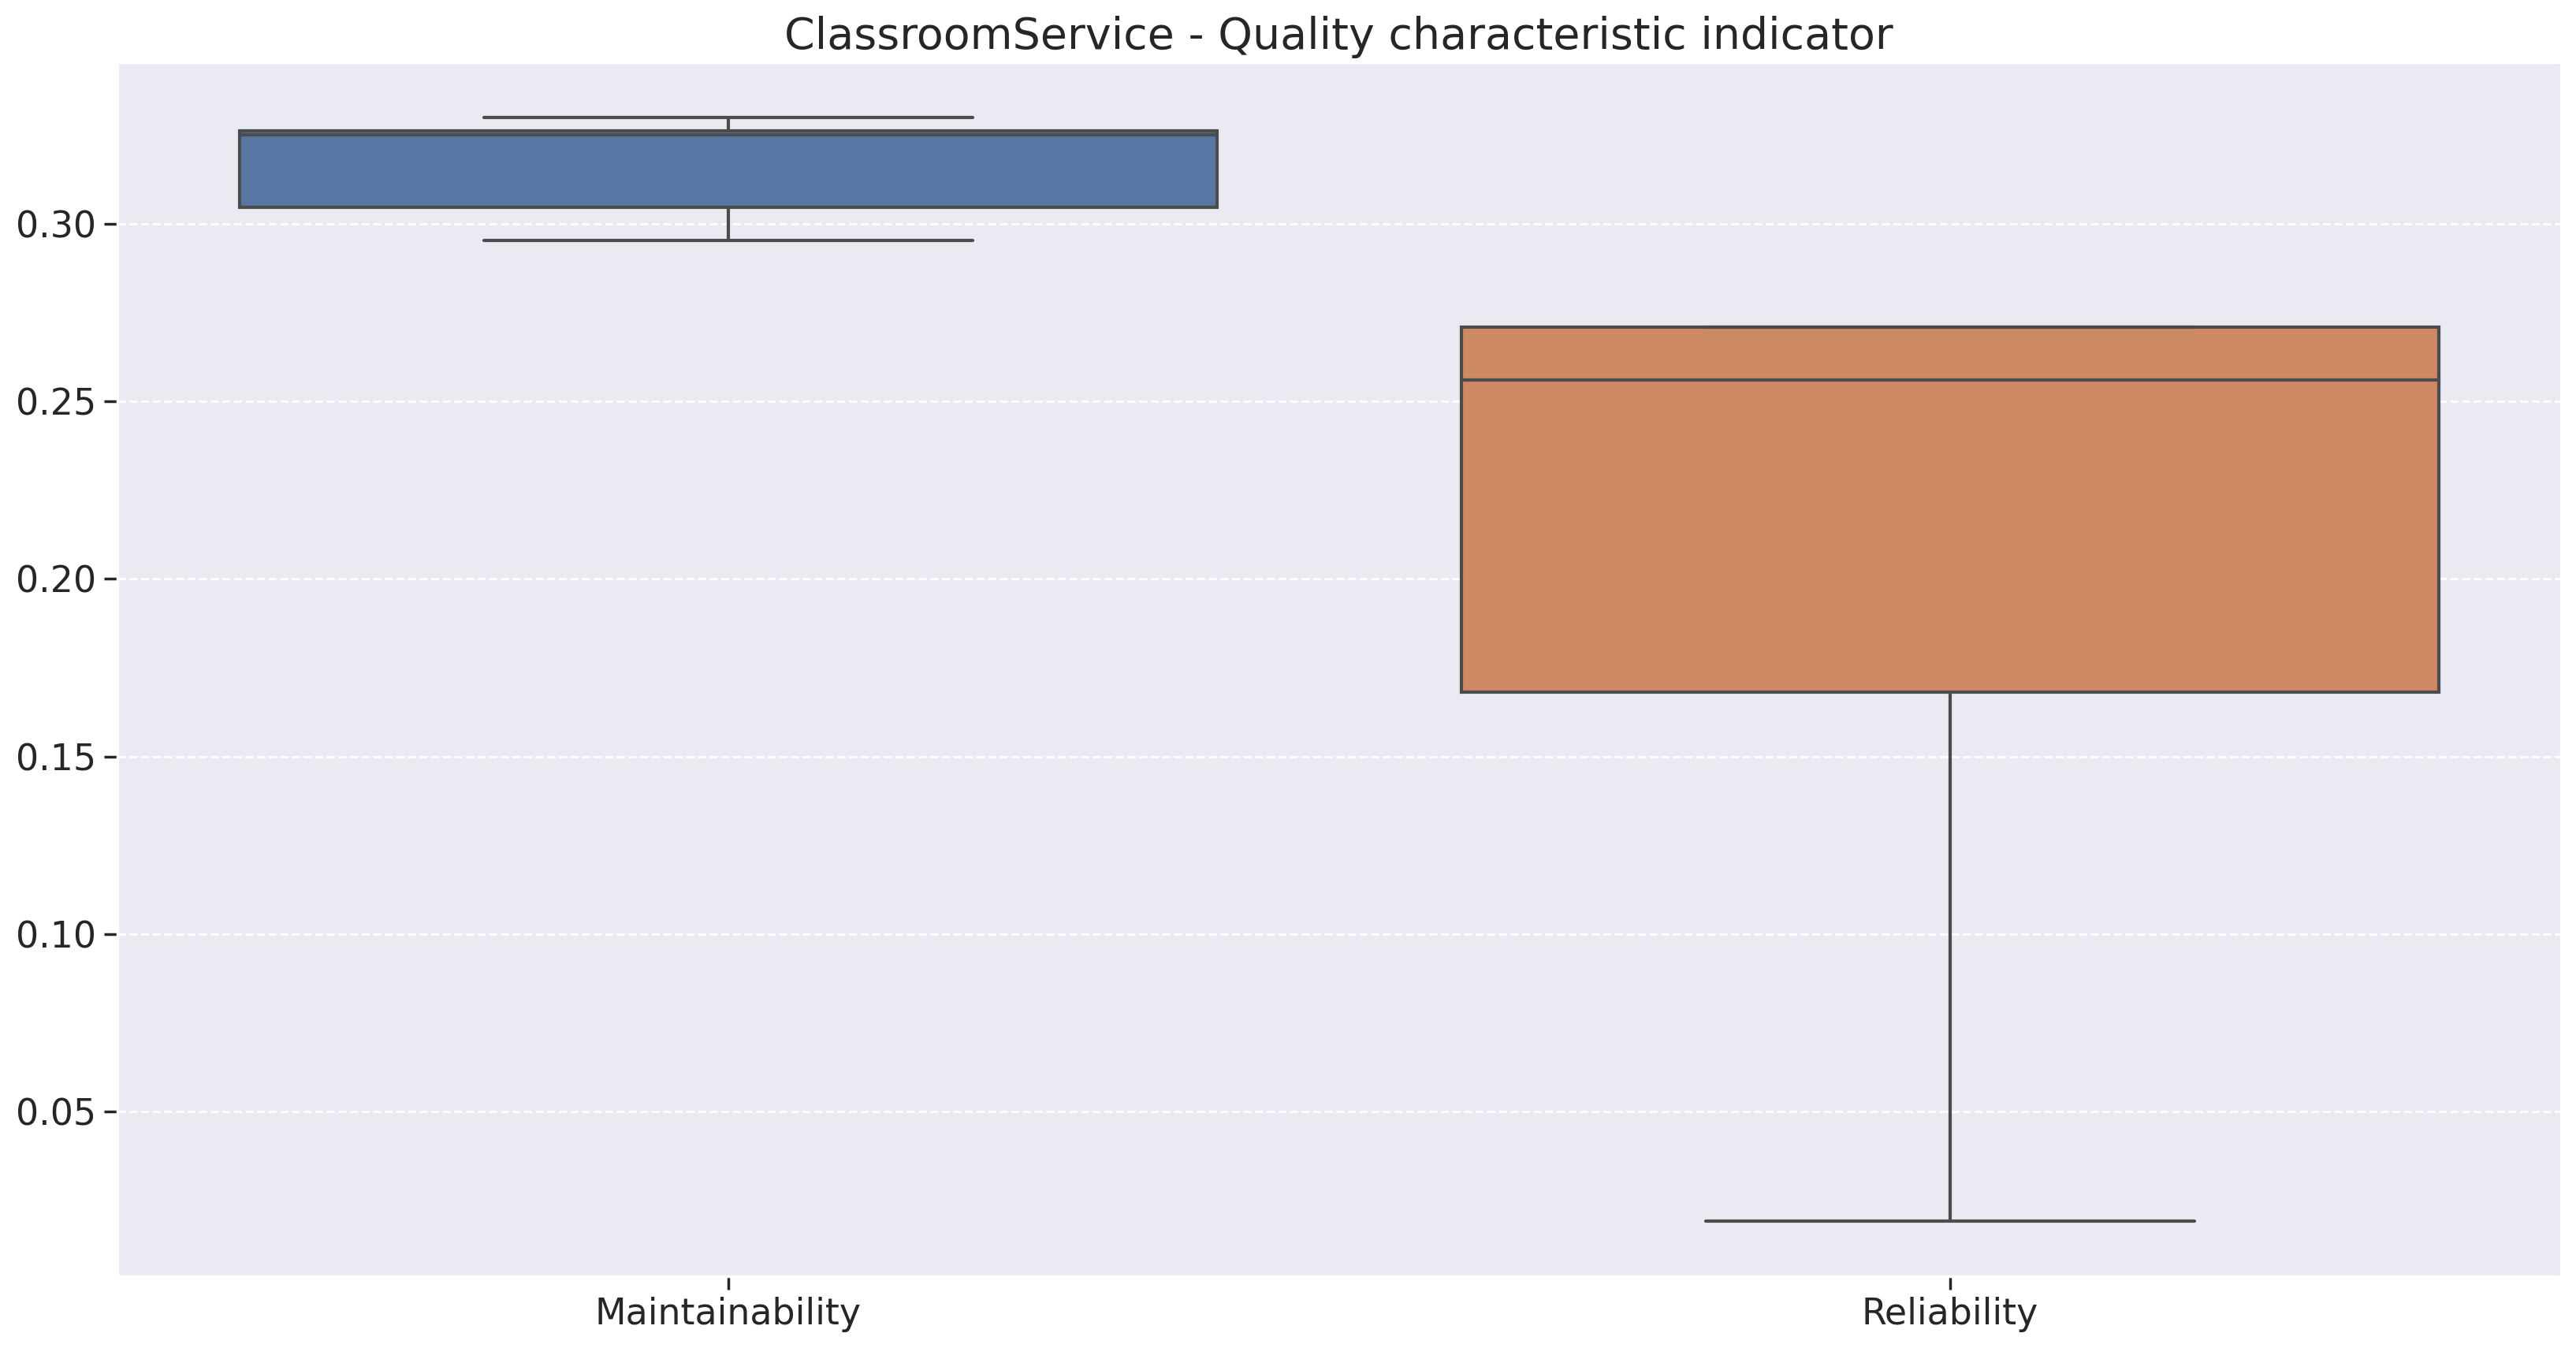

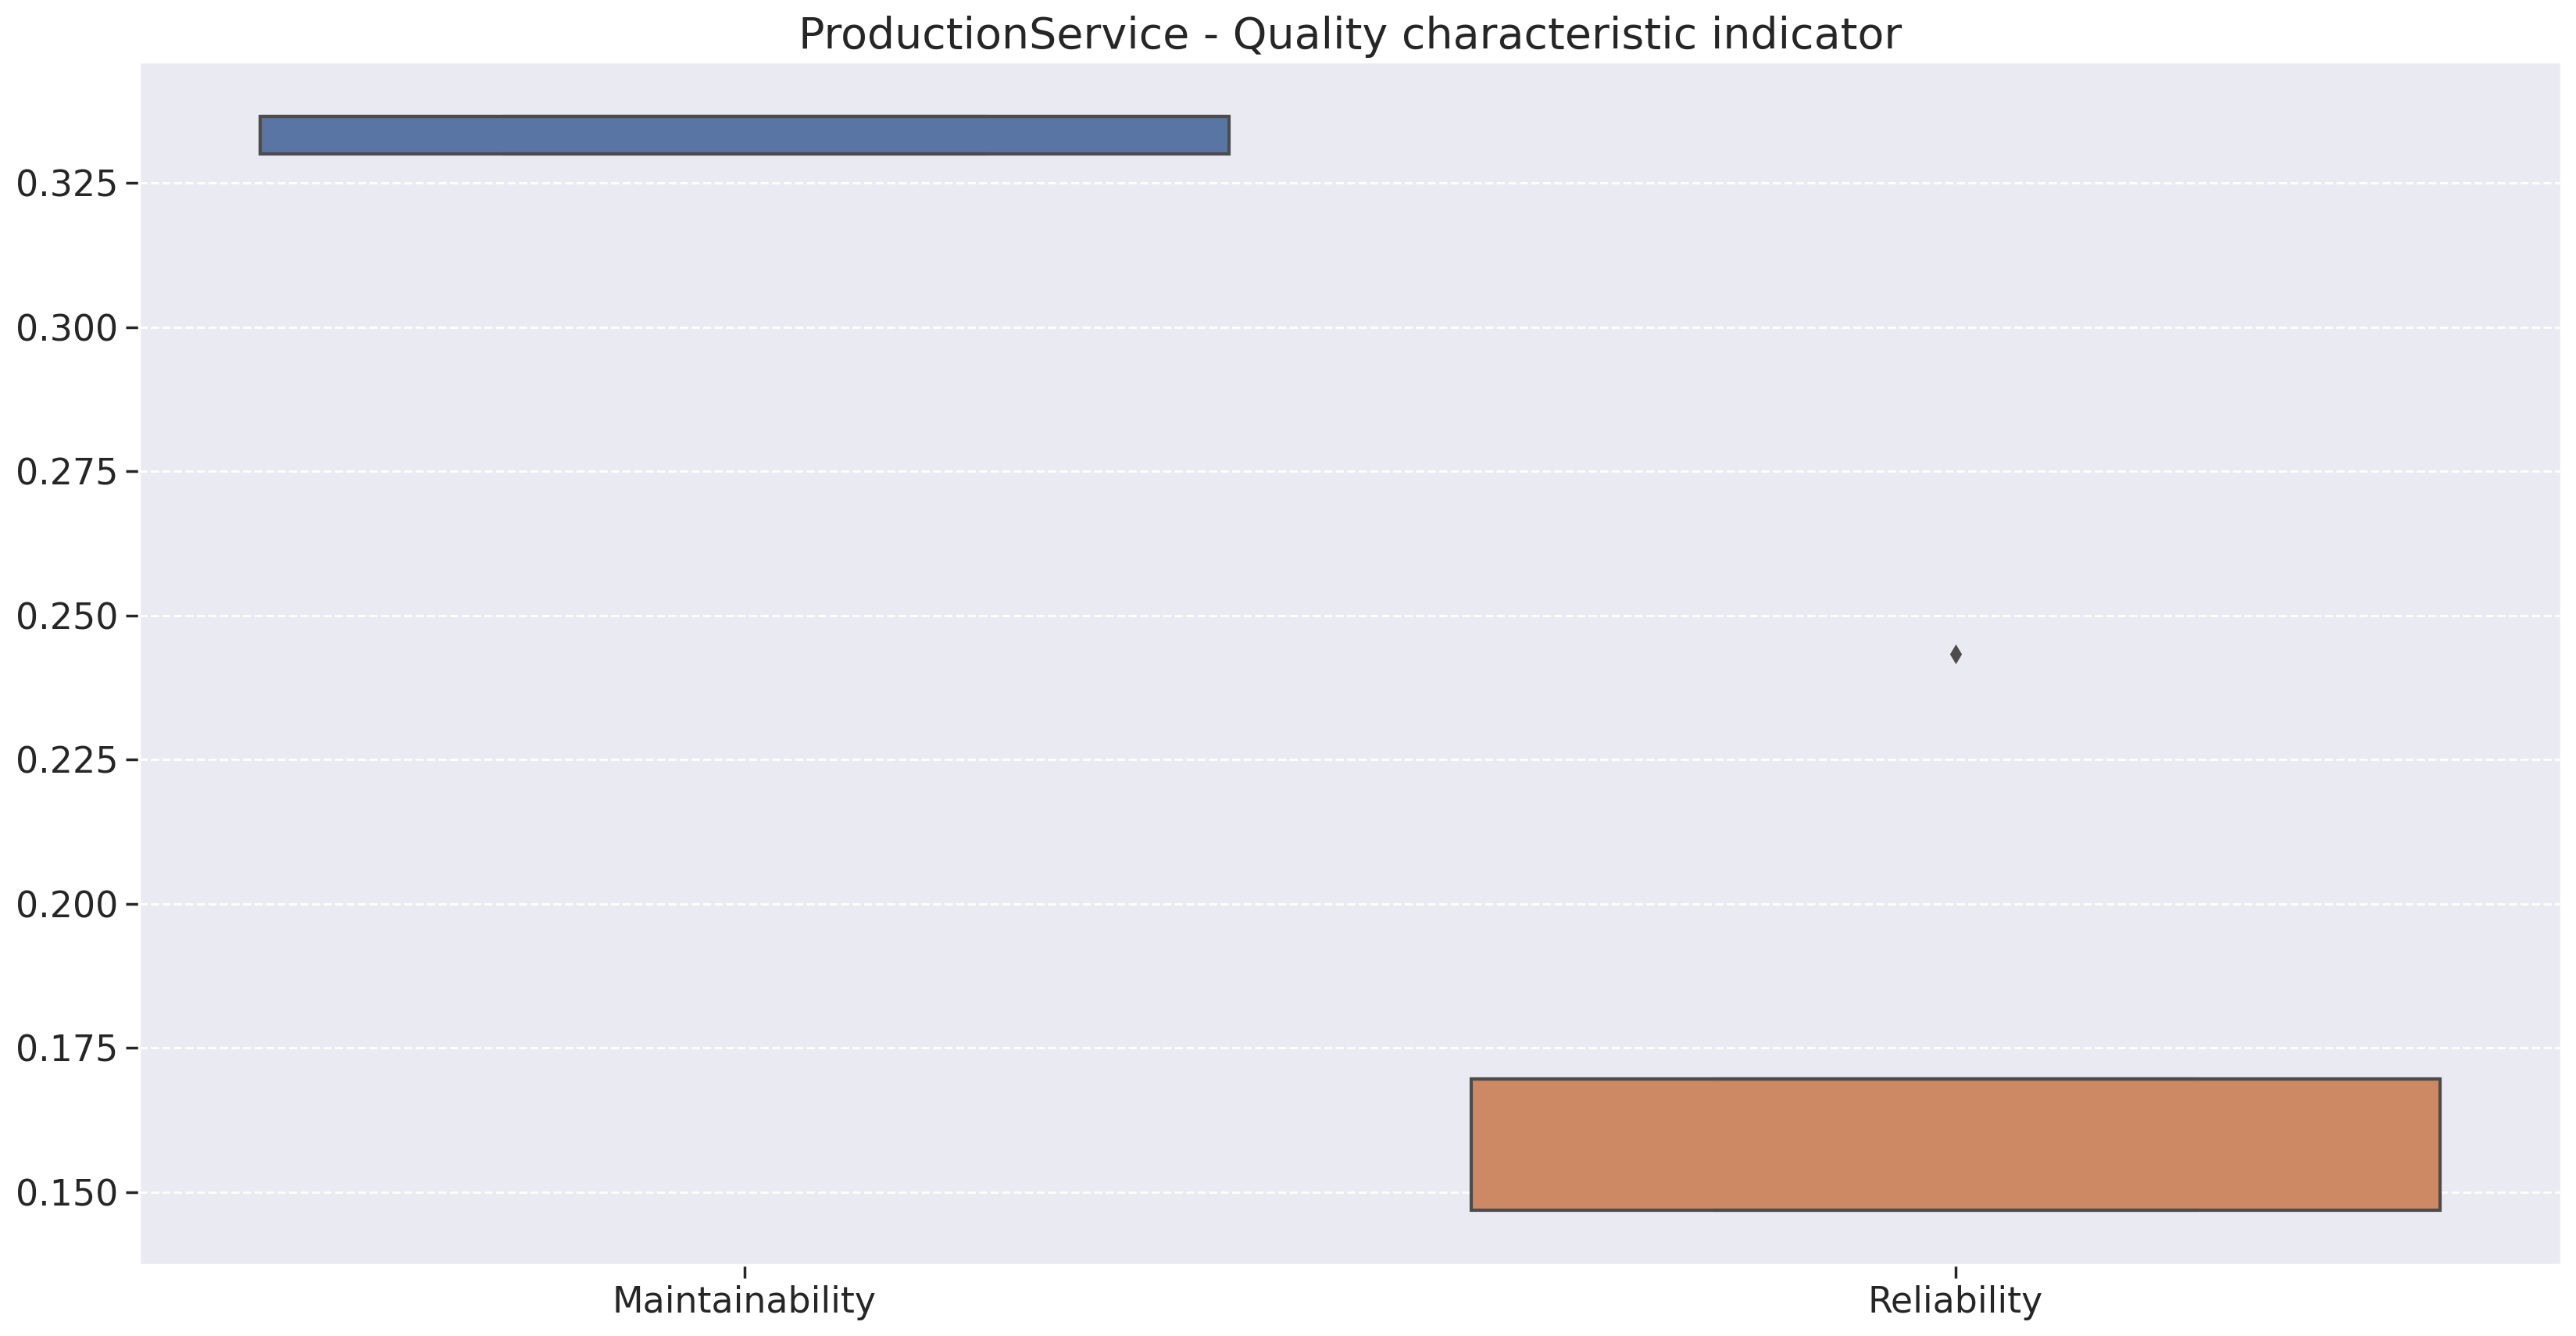

In [202]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))
    sns.boxplot(data=data[['Maintainability','Reliability']])

    plt.title(f"{name} - Quality characteristic indicator", fontsize=20)
    plt.show()

### Quality indicator visualization

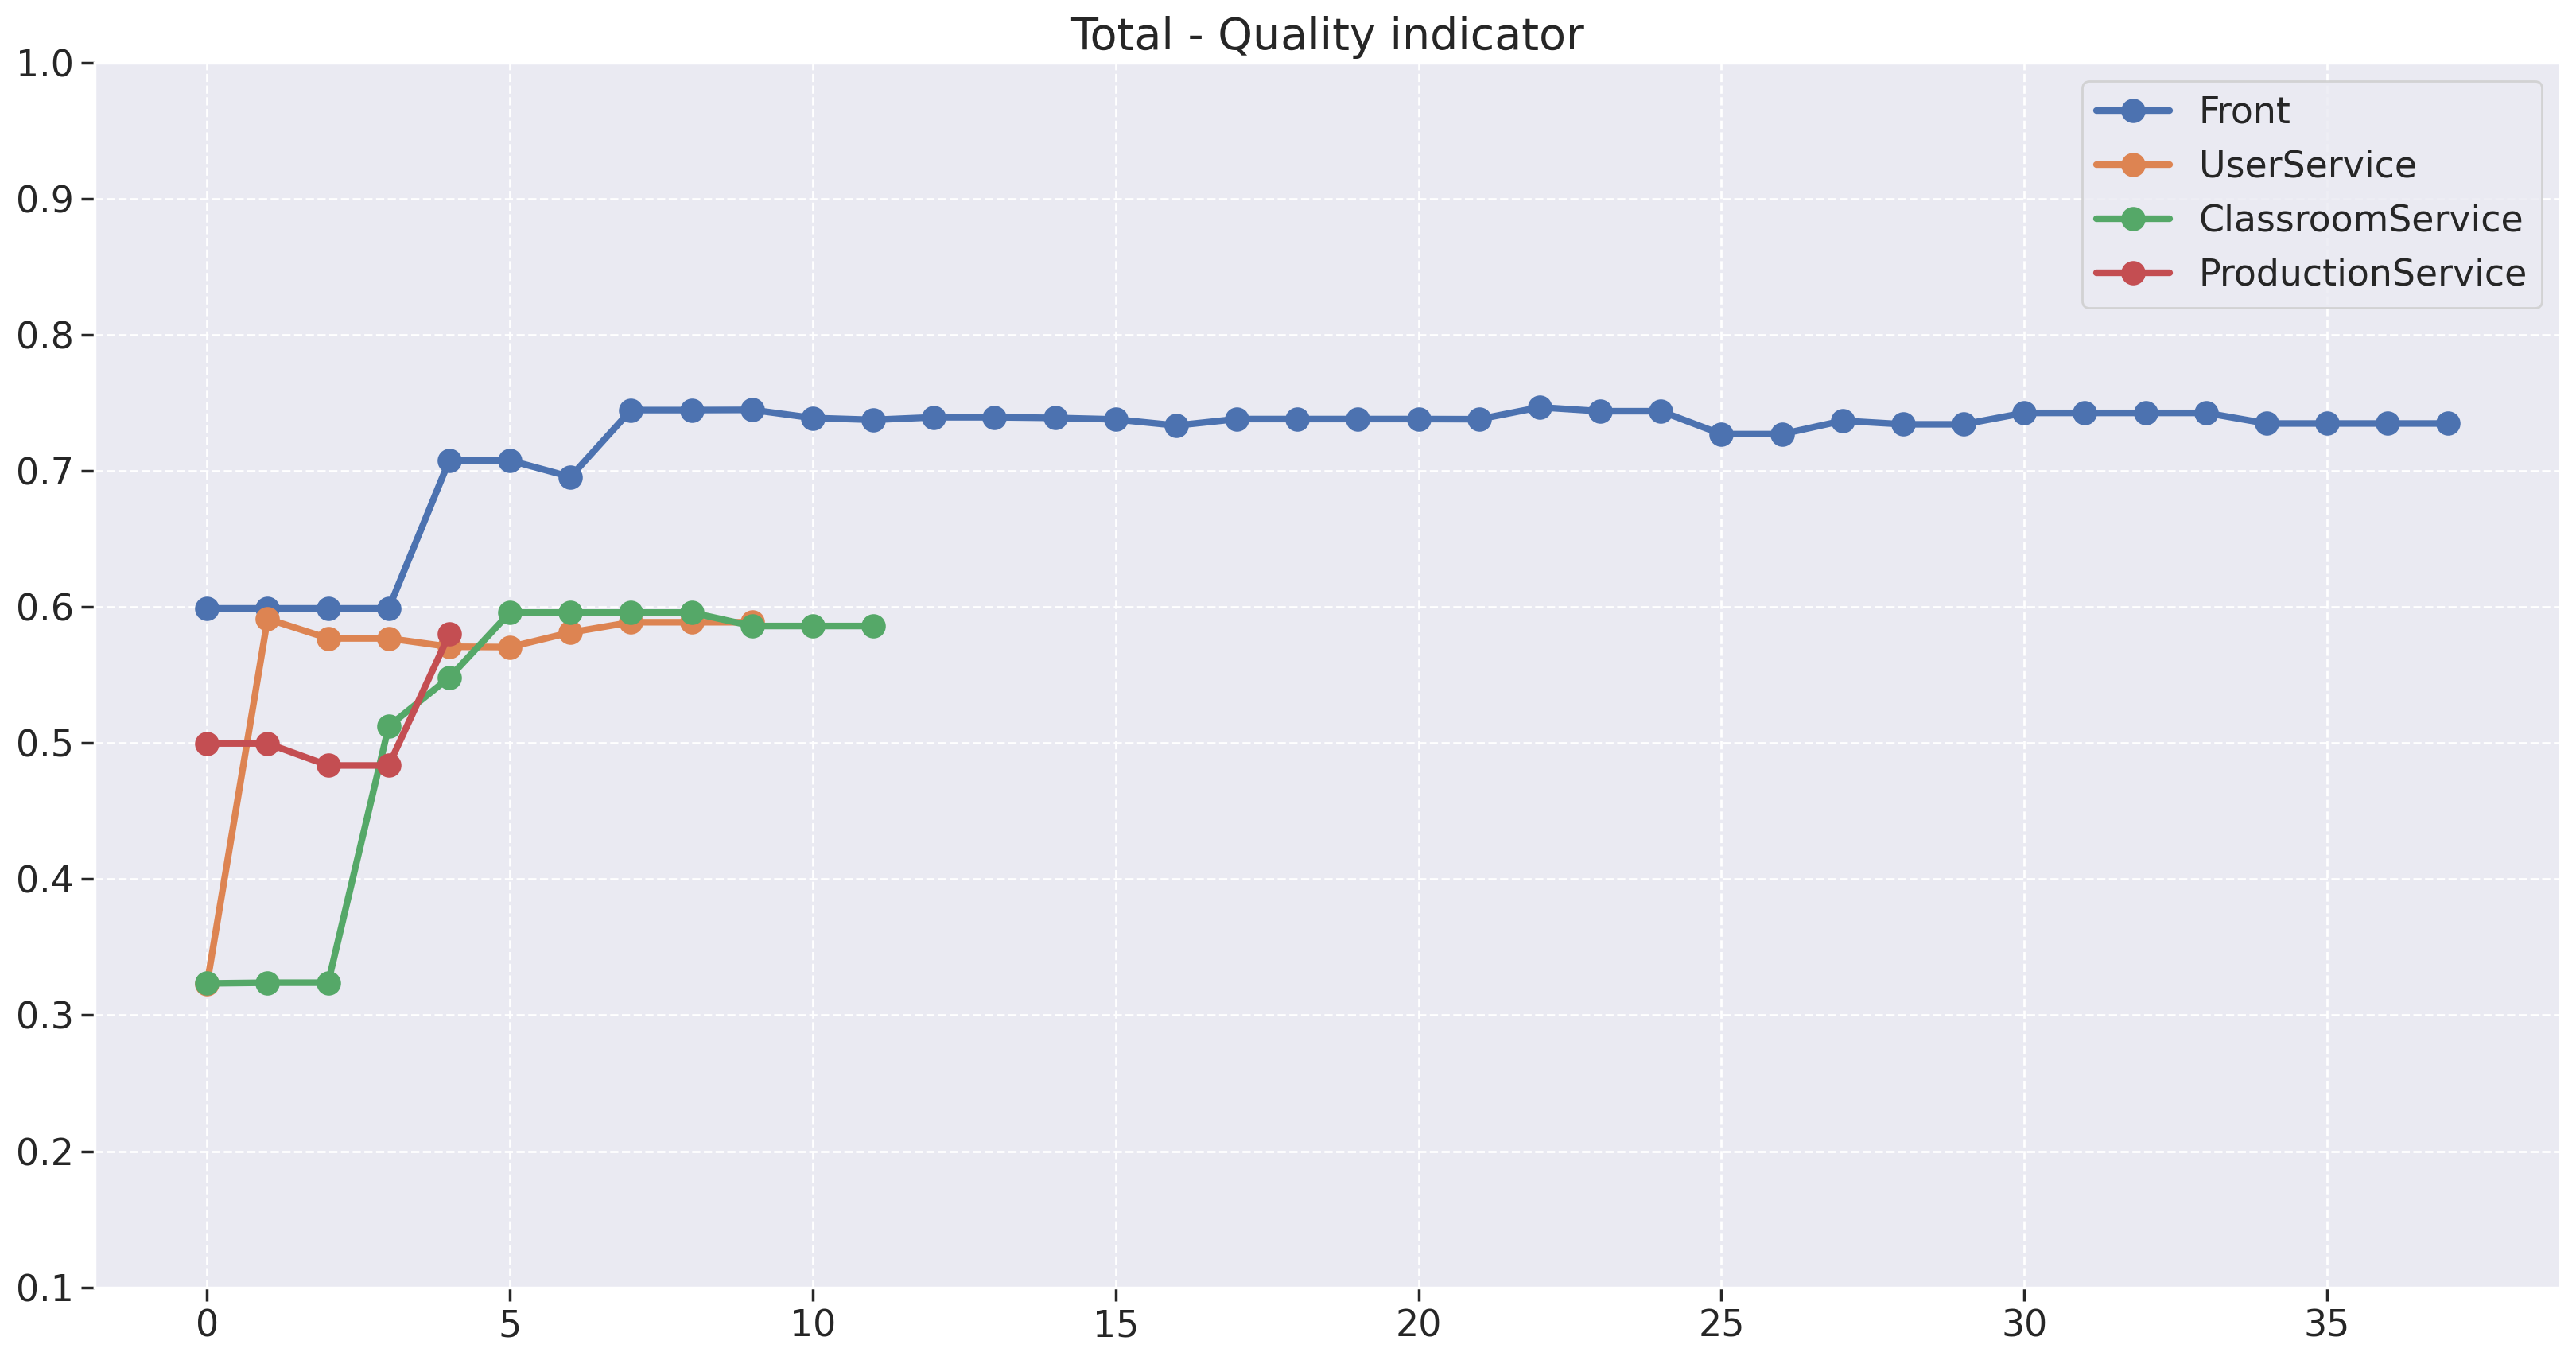

In [203]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=10, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

## Export data

In [204]:
# metrics_list = metrics.values()

# metrics_df = pd.concat(metrics_list, ignore_index=True)

# display(metrics_df)

# current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

# metrics_df.to_excel('./data/fga-eps-mds-2023.1-Amis--{}.xlsx'.format(current_datetime), index = False)

# metrics_df.to_csv('./data/fga-eps-mds-2023.1-Amis--{}.csv'.format(current_datetime), index = False)

## Perguntas

#### 1) No  microsserviço de backend que apresentar o pior indicador de manutenibilidade indique qual(is) o(s) módulos/arquivos mais críticos e explique como seu time tratou esse problema.
O UserService é o microsserviço com pior indicador de manutenibilidade. Foi o primeiro do backend a ser implementado, e para resolver esse problema a equipe propôs uma nova arquitetura para os microsserviços desenvolvidos em seguida.

#### 2) No microsserviço que apresentar o pior indicador de confiabilidade, explique como seu time tratou esse problema.
Ao analisar os gráficos de confiabilidade de microsserviços, pode-se concluir que o que está com indicador mais baixo é o ProductionService. Entretanto, podemos ver que o gráfico oscilou e o terminou atingindo o maior indice de confiabilidade, isso pode ter ocorrido devido as novas funcionalidades e melhorias inseridas, necessitando de uma refatoração do código.

#### 3) Explique o comportamento da qualidade do produto, observada ao longo do tempo do desenvolvimento, do projeto relacionado ao seu time.
Ao analisar o gráfico da qualidade do produto, podemos observar que tivemos um aumento relevante da qualidade ao longo do tempo, principalmente do Frontend, ClassroomService e ProductionService. O UserService decresceu no gráfico de qualidade, o que pode ter acontecido devido ao problemas enfrentados nos testes, e por motivos que nos levaram a mudar a arquitetura dos microsserviços desenvolvidos após o UserService.